### Modality Installation

In [1]:
# # create and activate your virtual environment
# python3.11 -m venv venv
# source venv/bin/activate
# pip install --extra-index-url https://europe-python.pkg.dev/prj-biomodal-modality/modality-pypi/simple modality

Imports and downloading demo dataset with the `load_biomodal_dataset` function.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns

In [3]:
# Seaborn customisation
sns.set_theme()
sns.set_style("whitegrid")
biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
sns.set_palette(biomodal_palette)

In [4]:
from modality.datasets import load_biomodal_dataset
from modality.annotation import (
    get_genes,
    get_transcription_end_region,
    get_tss_region,
    get_exons,
    get_introns,
    get_five_prime_utrs,
    get_three_prime_utrs,
    get_transcripts,
    get_cpg_islands,
)

2024-07-29 15:45:20 | INFO | [modality/read_locally.py:20] Setting cache dir as /var/folders/gg/n2wtdbl13m54f9xcjyl_k3qr0000gp/T. To modify alter the DS_BUCKET_CACHE environment variable


### Loading ES-E14 evoC dataset

In [5]:
from modality.contig_dataset import ContigDataset
def load_data():
    #downloads modality.contig_dataset.ContigDataset object
    ds = load_biomodal_dataset()
    # ds = ContigDataset.from_zarrz("../ES-E14.zarrz")
    ds = ds.drop_vars(["Input DNA Quantity (ng/sample)", "tech_replicate_number"])  
    ds = ds.sum(dim="sample_id", keep_attrs=True)
    ds = ds.expand_dims(dim="sample_id", axis=1)
    ds = ds.assign_coords(sample_id=["sample_0"])
    ds.assign_fractions(
        numerators=["num_modc", "num_mc", "num_hmc"],
        denominator="num_total_c",
        min_coverage=10,
        inplace=True,
    )
    return ds

In [6]:
ds = load_data()

# # ! gsutil cp -r gs://cegx-run1485/nf-results/duet-alpha-1.2.0_Mark_S_Hill_2024-02-29_0957_ES-E14_6bp/zarr_store/ES-E14.zarrz .
# ds = ContigDataset.from_zarrz("../ES-E14.zarrz")

2024-07-29 15:45:30 | WARNING | [modality/contig_dataset.py:340] "sample_id" coordinate is missing but expected to be set by many ContigDataset methods.
It can be added using the `assign_coords` method, e.g. `ds.assign_coords(sample_id = ("sample_id", ["sample1", "sample2"]))`
2024-07-29 15:45:30 | WARNING | [modality/contig_dataset.py:340] "sample_id" coordinate is missing but expected to be set by many ContigDataset methods.
It can be added using the `assign_coords` method, e.g. `ds.assign_coords(sample_id = ("sample_id", ["sample1", "sample2"]))`


Below is what our final `ContigDataset` looks like. It has 26 million CpGs along the pos dimension, and one sample along the sample_id dimension.

In [8]:
print(ds)

<modality.contig_dataset.ContigDataset>
<xarray.Dataset>
Dimensions:       (pos: 26074280, sample_id: 1)
Coordinates:
    contig        (pos) <U5 dask.array<chunksize=(100000,), meta=np.ndarray>
    ref_position  (pos) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
    strand        (pos) <U2 dask.array<chunksize=(100000,), meta=np.ndarray>
  * sample_id     (sample_id) <U8 'sample_0'
    group         (sample_id) <U8 'sample_0'
Dimensions without coordinates: pos
Data variables:
    num_c         (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_hmc       (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_mc        (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_modc      (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_other     (pos, sample_id) uint64 dask.array<chunksize=(100000, 1), meta=np.ndarray>
    num_total     (pos, sample_id) uint64 

subset ContigDataset by strand

In [9]:
import xarray as xr

plus_strand_mask = (ds['strand'].data == '+').compute()
minus_strand_mask = (ds['strand'].data == '-').compute()
plus_strand_mask_da = xr.DataArray(plus_strand_mask, dims=ds['strand'].dims, coords=ds['strand'].coords)
minus_strand_mask_da = xr.DataArray(minus_strand_mask, dims=ds['strand'].dims, coords=ds['strand'].coords)

plus_strand = ds.where(plus_strand_mask_da, drop=True)
minus_strand = ds.where(minus_strand_mask_da, drop=True)


In [10]:
from modality.contig_dataset import set_contig_slices, cast_result

def refresh_slices(subset_data):
    if subset_data.pos.size == 0:
            raise ValueError(
                "Subset is empty. Please check the coverage values and method used."
            )
    else:
        slices = [x for x in subset_data.attrs if x.startswith("slice")]
        for sl in slices:
            subset_data.attrs.pop(sl)

        return set_contig_slices(subset_data)

    # We need to rechunk here to resolve the irregular chunk sizes that result from the subseting
    # subset_data = rechunk_dataset(
    #     template_data=subset_data, axis1_chunk_size=subset_data.sample_id.size
    # )

plus_strand = cast_result(refresh_slices(plus_strand.ds))

minus_strand = cast_result(refresh_slices(minus_strand.ds))


2024-07-29 15:46:25 | INFO | [modality/contig_slices.py:25] Computing available chromosomes.
2024-07-29 15:46:25 | INFO | [modality/contig_slices.py:44] Found available contigs: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,X,Y,MT.
2024-07-29 15:46:25 | INFO | [modality/contig_slices.py:25] Computing available chromosomes.
2024-07-29 15:46:25 | INFO | [modality/contig_slices.py:44] Found available contigs: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,X,Y,MT.


In [11]:
plus_strand

ContigDataset(data_vars=Data variables:
    num_c        (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_hmc      (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_mc       (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_modc     (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_other    (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_total    (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_total_c  (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    frac_modc    (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    frac_mc      (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    frac_hmc     (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>, coords=Coordinates:
    contig        (pos) <U5 dask.array<chunksize=(50000,), meta=np.ndarray>
    ref_position  (pos) int64 dask.array<chunksize=(50000,), meta=np.ndarray>
    strand        (pos) <U2 dask.array<chunksize=(50000,), meta=np.ndarray>
  * sample_id     (sample_id) <U8 'sample_0'
    group         (sample_id) <U8 'sample_0', attrs={'context': 'CG', 'context_sampling': 1.0, 'contigs': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'MT'], 'coordinate_basis': 0, 'description': 'An evoC dataset of mouse ES-E14 cells, data contains 4 technical replicates.\nThese data aligned to the mm38 genome.', 'fasta_path': 'GRCm38-ss-ctrls-v23.fa.gz', 'frac_denominator': 'num_total_c', 'frac_min_coverage': 10, 'input_path': ['CEG1485-EL01-D1115-001.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-002.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-003.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-004.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz'], 'quant_type': 'quant6L', 'ref_name': 'GRCm38', 'sample_ids': ['CEG1485-EL01-D1115-001', 'CEG1485-EL01-D1115-002', 'CEG1485-EL01-D1115-003', 'CEG1485-EL01-D1115-004'], 'slice_1': slice(0, 868704, 1), 'slice_10': slice(6973201, 7655712, 1), 'slice_11': slice(7655712, 8424647, 1), 'slice_12': slice(8424647, 9002865, 1), 'slice_13': slice(9002865, 9598341, 1), 'slice_14': slice(9598341, 10160405, 1), 'slice_15': slice(10160405, 10705365, 1), 'slice_16': slice(10705365, 11159809, 1), 'slice_17': slice(11159809, 11693082, 1), 'slice_18': slice(11693082, 12139087, 1), 'slice_19': slice(12139087, 12505171, 1), 'slice_2': slice(868704, 1831040, 1), 'slice_3': slice(1831040, 2521902, 1), 'slice_4': slice(2521902, 3323979, 1), 'slice_5': slice(3323979, 4160524, 1), 'slice_6': slice(4160524, 4857217, 1), 'slice_7': slice(4857217, 5576860, 1), 'slice_8': slice(5576860, 6302520, 1), 'slice_9': slice(6302520, 6973201, 1), 'slice_MT': slice(13036853, 13037140, 1), 'slice_X': slice(12505171, 12880337, 1), 'slice_Y': slice(12880337, 13036853, 1)})

In [12]:
minus_strand

ContigDataset(data_vars=Data variables:
    num_c        (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_hmc      (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_mc       (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_modc     (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_other    (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_total    (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    num_total_c  (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    frac_modc    (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    frac_mc      (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>
    frac_hmc     (pos, sample_id) float64 dask.array<chunksize=(50000, 1), meta=np.ndarray>, coords=Coordinates:
    contig        (pos) <U5 dask.array<chunksize=(50000,), meta=np.ndarray>
    ref_position  (pos) int64 dask.array<chunksize=(50000,), meta=np.ndarray>
    strand        (pos) <U2 dask.array<chunksize=(50000,), meta=np.ndarray>
  * sample_id     (sample_id) <U8 'sample_0'
    group         (sample_id) <U8 'sample_0', attrs={'context': 'CG', 'context_sampling': 1.0, 'contigs': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'MT'], 'coordinate_basis': 0, 'description': 'An evoC dataset of mouse ES-E14 cells, data contains 4 technical replicates.\nThese data aligned to the mm38 genome.', 'fasta_path': 'GRCm38-ss-ctrls-v23.fa.gz', 'frac_denominator': 'num_total_c', 'frac_min_coverage': 10, 'input_path': ['CEG1485-EL01-D1115-001.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-002.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-003.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-004.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz'], 'quant_type': 'quant6L', 'ref_name': 'GRCm38', 'sample_ids': ['CEG1485-EL01-D1115-001', 'CEG1485-EL01-D1115-002', 'CEG1485-EL01-D1115-003', 'CEG1485-EL01-D1115-004'], 'slice_1': slice(0, 868704, 1), 'slice_10': slice(6973201, 7655712, 1), 'slice_11': slice(7655712, 8424647, 1), 'slice_12': slice(8424647, 9002865, 1), 'slice_13': slice(9002865, 9598341, 1), 'slice_14': slice(9598341, 10160405, 1), 'slice_15': slice(10160405, 10705365, 1), 'slice_16': slice(10705365, 11159809, 1), 'slice_17': slice(11159809, 11693082, 1), 'slice_18': slice(11693082, 12139087, 1), 'slice_19': slice(12139087, 12505171, 1), 'slice_2': slice(868704, 1831040, 1), 'slice_3': slice(1831040, 2521902, 1), 'slice_4': slice(2521902, 3323979, 1), 'slice_5': slice(3323979, 4160524, 1), 'slice_6': slice(4160524, 4857217, 1), 'slice_7': slice(4857217, 5576860, 1), 'slice_8': slice(5576860, 6302520, 1), 'slice_9': slice(6302520, 6973201, 1), 'slice_MT': slice(13036853, 13037140, 1), 'slice_X': slice(12505171, 12880337, 1), 'slice_Y': slice(12880337, 13036853, 1)})

### Loading mm10 (GRCm38) reference genome from [GENCODE](https://www.gencodegenes.org/)

In [13]:
gene_filter = {
    "gene_type": "protein_coding",
    "source": "HAVANA",
}

genes = get_genes(
    reference="mm10",
    as_pyranges=True,
    filterby=gene_filter,
)

# genes = genes.unstrand()
genes.head(5)

2024-07-29 15:46:28 | INFO | [modality/run_subprocess.py:15] gunzip --force /var/folders/gg/n2wtdbl13m54f9xcjyl_k3qr0000gp/T/f704b1b3ac2dd1f11f9e46d01bc321bc_gencode.vM25.basic.annotation.gff3.gz
2024-07-29 15:46:29 | INFO | [modality/run_subprocess.py:15] sort -k1,1  -k4,4n -o /var/folders/gg/n2wtdbl13m54f9xcjyl_k3qr0000gp/T/f704b1b3ac2dd1f11f9e46d01bc321bc_gencode.vM25.basic.annotation.gff3 /var/folders/gg/n2wtdbl13m54f9xcjyl_k3qr0000gp/T/f704b1b3ac2dd1f11f9e46d01bc321bc_gencode.vM25.basic.annotation.gff3
2024-07-29 15:46:40 | INFO | [modality/run_subprocess.py:15] bgzip --threads 10 --force /var/folders/gg/n2wtdbl13m54f9xcjyl_k3qr0000gp/T/f704b1b3ac2dd1f11f9e46d01bc321bc_gencode.vM25.basic.annotation.gff3
2024-07-29 15:46:40 | INFO | [modality/run_subprocess.py:15] tabix -f -p gff /var/folders/gg/n2wtdbl13m54f9xcjyl_k3qr0000gp/T/f704b1b3ac2dd1f11f9e46d01bc321bc_gencode.vM25.basic.annotation.gff3.gz
2024-07-29 15:46:47 | INFO | [modality/annotation.py:437] Removing readthrough_gene t

,Chromosome,Source,Type,Start,End,Score,Strand,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID
0,1,HAVANA,gene,4807787,4848409,.,+,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0
1,1,HAVANA,gene,4807891,4886769,.,+,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1
2,1,HAVANA,gene,4857813,4897908,.,+,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2
3,1,HAVANA,gene,5070017,5162528,.,+,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3
4,1,HAVANA,gene,5588465,5606130,.,+,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4


In [14]:
print(f" all genes: {len(genes)}")
print(f" unique gene id: {len(genes.df['Id'])}")

transcripts = get_transcripts(
        reference="mm10",
        contig=None,
        start=None,
        end=None,
        as_pyranges=False,
    )
print(len(transcripts))


 all genes: 21673
 unique gene id: 21673


2024-07-29 15:46:54 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


40524


### Identify transcript for each gene

In [15]:
transcripts = get_transcripts(
        reference="mm10",
        contig=None,
        start=None,
        end=None,
        as_pyranges=False,
    )

def select_transcript_based_on_tag(df):
    # for each transcript in df, select the one with the highest priority tag
    # priorities are:
        # 1. 'basic,appris_principal_1,CCDS'
        # 2. 'basic,appris_principal_1'
        # 3. 'basic,CCDS'
        # 4. 'basic'
    # but with 'exp_conf' (experimentally confirmed) tag, the priority is higher.
    
    priorties = {
        'basic,appris_principal_1,exp_conf,CCDS': 1,
        'basic,appris_principal_1,CCDS': 1,
        'basic,appris_principal_1,exp_conf': 3,
        'basic,appris_principal_1': 4,
        'basic,exp_conf,CCDS': 5,
        'basic,CCDS': 6,
        'basic,exp_conf': 7,
        'basic': 8
    }

    # sort the dataframe by the priority of the tags
    df['tag_priority'] = df.tag.map(priorties)

    df = df.sort_values(by='tag_priority')

    # drop duplicates, keeping the first one
    df = df.drop_duplicates(subset='gene_id', keep='first')

    return df[["gene_id", "transcript_id"]]

2024-07-29 15:47:00 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


In [16]:
selected_transcripts = transcripts.groupby('gene_id').apply(
    select_transcript_based_on_tag
    ).reset_index(drop=True)
selected_transcripts.head()

# Create dictionary for gene_id to transcript_id mapping
gene_to_transcription = selected_transcripts.set_index('gene_id')['transcript_id'].to_dict()
print(f"There are {len(gene_to_transcription)} genes with unique transcript ids")

There are 21541 genes with unique transcript ids


reviewing genes with missing transcripts...
Majority has an empty tag, overlapping_locus, reference_genome_error or fragmented_locus

In [17]:
# Function to map transcription_id
def map_transcription_id(gene_id, gene_to_transcription):
    return gene_to_transcription.get(gene_id, None)


# Map transcription_id 
genes_df = genes.df
genes_df['Transcript_id'] = genes_df['Gene_id'].map(lambda gene_id: map_transcription_id(gene_id, gene_to_transcription))
genes_clean = pr.PyRanges(genes_df)

# Handle missing gene_ids
missing_gene_ids = genes_clean.df[genes_clean.df['Transcript_id'].isna()]['Gene_id'].tolist()

filtered_genes = genes_clean.df[genes_clean.df['Gene_id'].isin(missing_gene_ids)]
print(f"Tags for {len(filtered_genes)} missing genes:")
print(filtered_genes['Tag'].value_counts())

genes_clean = genes_clean[~genes_clean.df['Transcript_id'].isna()]


print(f"all genes: {len(genes)}")
print(f"all genes with annotated transcripts: {len(genes_clean)}")
genes_clean


Tags for 132 missing genes:
Tag
                                                 87
overlapping_locus                                13
reference_genome_error                           10
fragmented_locus                                  9
ncRNA_host,fragmented_locus                       2
ncRNA_host                                        2
overlapping_locus,reference_genome_error          2
ncRNA_host,reference_genome_error                 2
ncRNA_host,overlapping_locus                      2
fragmented_locus,reference_genome_error           1
fragmented_locus,overlapping_locus                1
ncRNA_host,fragmented_locus,overlapping_locus     1
Name: count, dtype: int64
all genes: 21673
all genes with annotated transcripts: 21541


,Chromosome,Source,Type,Start,End,Score,Strand,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,4807787,4848409,.,+,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0,ENSMUST00000027036.10
1,1,HAVANA,gene,4807891,4886769,.,+,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1,ENSMUST00000155020.1
2,1,HAVANA,gene,4857813,4897908,.,+,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2,ENSMUST00000081551.13
3,1,HAVANA,gene,5070017,5162528,.,+,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3,ENSMUST00000192847.5
4,1,HAVANA,gene,5588465,5606130,.,+,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4,ENSMUST00000160777.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,Y,HAVANA,gene,78835720,78838055,.,-,.,ENSMUSG00000094739.2,ENSMUSG00000094739.2,protein_coding,Gm20806,2,MGI:5434162,OTTMUSG00000046577.2,,21668,ENSMUST00000190349.1
21537,Y,HAVANA,gene,79148788,79151121,.,-,.,ENSMUSG00000095867.2,ENSMUSG00000095867.2,protein_coding,Gm20917,2,MGI:5434273,OTTMUSG00000046619.2,,21669,ENSMUST00000188706.1
21538,Y,HAVANA,gene,84562571,84564906,.,-,.,ENSMUSG00000094660.2,ENSMUSG00000094660.2,protein_coding,Gm21394,2,MGI:5434749,OTTMUSG00000045415.1,,21670,ENSMUST00000189463.1
21539,Y,HAVANA,gene,85528516,85530907,.,-,.,ENSMUSG00000095650.2,ENSMUSG00000095650.2,protein_coding,Gm20854,2,MGI:5434210,OTTMUSG00000042966.1,,21671,ENSMUST00000181549.1


### Extract 200 bp before TSS transcription start site

In [18]:
default_args = {
    "contig": None,
    "start": None,
    "end": None,
    "reference": "mm10",
    "as_pyranges": True,
    "protein_coding": True,
    "filterby": None,
}

before_tss = get_tss_region(
    start_offset=-200,
    span=200,
    **default_args,
)

print(f"all before_tss regions: {len(before_tss)}")
# Map transcription_id 
before_tss_df = before_tss.df
before_tss_df['Transcript_id'] = before_tss_df['Gene_id'].map(lambda gene_id: map_transcription_id(gene_id, gene_to_transcription))
before_tss = pr.PyRanges(before_tss_df)
before_tss = before_tss[~before_tss.df['Transcript_id'].isna()]

print(f"before_tss regions with transcripts: {len(before_tss)}")


2024-07-29 15:47:16 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


all before_tss regions: 21673
before_tss regions with transcripts: 21541


### Extract 1000 bp after TES transcription end site

In [19]:
after_tes = get_transcription_end_region(
    start_offset=0,
    span=1000,
    **default_args,
)

print(f"all after_tes regions: {len(after_tes)}")
# Map transcription_id 
after_tes_df = after_tes.df
after_tes_df['Transcript_id'] = after_tes_df['Gene_id'].map(lambda gene_id: map_transcription_id(gene_id, gene_to_transcription))
after_tes = pr.PyRanges(before_tss_df)
after_tes = after_tes[~after_tes.df['Transcript_id'].isna()]

print(f"after_tes regions with transcripts: {len(after_tes)}")

2024-07-29 15:47:22 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


all after_tes regions: 21673
after_tes regions with transcripts: 21541


In [20]:
#split strands
before_tss_strand1 = pr.PyRanges(before_tss.df[before_tss.df["Strand"]=="+"])
before_tss_strand2 = pr.PyRanges(before_tss.df[before_tss.df["Strand"]=="-"])
after_tes_strand1 = pr.PyRanges(after_tes.df[after_tes.df["Strand"]=="+"])
after_tes_strand2 = pr.PyRanges(after_tes.df[after_tes.df["Strand"]=="-"])

before_tss_strand1 = before_tss_strand1.unstrand()
before_tss_strand2 = before_tss_strand2.unstrand()
after_tes_strand1 = after_tes_strand1.unstrand()
after_tes_strand2 = after_tes_strand2.unstrand()

In [21]:
before_tss_strand1

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,4807587,4807787,.,.,ENSMUSG00000025903.14,ENSMUSG00000025903.14,protein_coding,Lypla1,2,MGI:1344588,OTTMUSG00000021562.4,overlapping_locus,0,ENSMUST00000027036.10
1,1,HAVANA,gene,4807691,4807891,.,.,ENSMUSG00000104217.1,ENSMUSG00000104217.1,protein_coding,Gm37988,2,MGI:5611216,OTTMUSG00000050100.1,overlapping_locus,1,ENSMUST00000155020.1
2,1,HAVANA,gene,4857613,4857813,.,.,ENSMUSG00000033813.15,ENSMUSG00000033813.15,protein_coding,Tcea1,2,MGI:1196624,OTTMUSG00000042348.1,overlapping_locus,2,ENSMUST00000081551.13
3,1,HAVANA,gene,5069817,5070017,.,.,ENSMUSG00000033793.12,ENSMUSG00000033793.12,protein_coding,Atp6v1h,2,MGI:1914864,OTTMUSG00000050145.9,,3,ENSMUST00000192847.5
4,1,HAVANA,gene,5588265,5588465,.,.,ENSMUSG00000025905.14,ENSMUSG00000025905.14,protein_coding,Oprk1,2,MGI:97439,OTTMUSG00000034734.3,,4,ENSMUST00000160777.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10735,Y,HAVANA,gene,87116620,87116820,.,.,ENSMUSG00000094399.7,ENSMUSG00000094399.7,protein_coding,Gm21477,2,MGI:5434832,OTTMUSG00000047083.1,,21601,ENSMUST00000189543.6
10736,Y,HAVANA,gene,87550765,87550965,.,.,ENSMUSG00000099856.1,ENSMUSG00000099856.1,protein_coding,Gm20906,2,MGI:5434262,OTTMUSG00000047138.1,,21602,ENSMUST00000186493.1
10737,Y,HAVANA,gene,88053114,88053314,.,.,ENSMUSG00000101915.1,ENSMUSG00000101915.1,protein_coding,Gm28102,2,MGI:5578808,OTTMUSG00000047149.1,,21603,ENSMUST00000187146.1
10738,Y,HAVANA,gene,89052605,89052805,.,.,ENSMUSG00000102045.1,ENSMUSG00000102045.1,protein_coding,Gm21294,2,MGI:5434649,OTTMUSG00000047309.1,,21604,ENSMUST00000186443.1


In [22]:
before_tss_strand2

,Chromosome,Source,Type,Start,End,Score,Phase,Id,Gene_id,Gene_type,Gene_name,Level,Mgi_id,Havana_gene,Tag,Ranges_ID,Transcript_id
0,1,HAVANA,gene,3671497,3671697,.,.,ENSMUSG00000051951.5,ENSMUSG00000051951.5,protein_coding,Xkr4,2,MGI:3528744,OTTMUSG00000026353.2,,611,ENSMUST00000070533.4
1,1,HAVANA,gene,4409240,4409440,.,.,ENSMUSG00000025900.13,ENSMUSG00000025900.13,protein_coding,Rp1,2,MGI:1341105,OTTMUSG00000049985.3,overlapping_locus,612,ENSMUST00000027032.5
2,1,HAVANA,gene,4497353,4497553,.,.,ENSMUSG00000025902.13,ENSMUSG00000025902.13,protein_coding,Sox17,2,MGI:107543,OTTMUSG00000050014.7,,613,ENSMUST00000027035.9
3,1,HAVANA,gene,4785738,4785938,.,.,ENSMUSG00000033845.13,ENSMUSG00000033845.13,protein_coding,Mrpl15,2,MGI:1351639,OTTMUSG00000029329.3,,614,ENSMUST00000156816.6
4,1,HAVANA,gene,5070284,5070484,.,.,ENSMUSG00000002459.17,ENSMUSG00000002459.17,protein_coding,Rgs20,2,MGI:1929866,OTTMUSG00000029338.4,overlapping_locus,615,ENSMUST00000002533.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10796,Y,HAVANA,gene,78838055,78838255,.,.,ENSMUSG00000094739.2,ENSMUSG00000094739.2,protein_coding,Gm20806,2,MGI:5434162,OTTMUSG00000046577.2,,21668,ENSMUST00000190349.1
10797,Y,HAVANA,gene,79151121,79151321,.,.,ENSMUSG00000095867.2,ENSMUSG00000095867.2,protein_coding,Gm20917,2,MGI:5434273,OTTMUSG00000046619.2,,21669,ENSMUST00000188706.1
10798,Y,HAVANA,gene,84564906,84565106,.,.,ENSMUSG00000094660.2,ENSMUSG00000094660.2,protein_coding,Gm21394,2,MGI:5434749,OTTMUSG00000045415.1,,21670,ENSMUST00000189463.1
10799,Y,HAVANA,gene,85530907,85531107,.,.,ENSMUSG00000095650.2,ENSMUSG00000095650.2,protein_coding,Gm20854,2,MGI:5434210,OTTMUSG00000042966.1,,21671,ENSMUST00000181549.1


### Extract 3`UTRs

In [23]:
three_prime_utrs = get_three_prime_utrs(reference="mm10")
three_prime_utrs = three_prime_utrs[
    three_prime_utrs.Transcript_id.isin(selected_transcripts.transcript_id)
    ]

#split strands
print(f"three_prime_utrs shape: {three_prime_utrs.df.shape}")
three_prime_utrs_strand1 = pr.PyRanges(three_prime_utrs.df[three_prime_utrs.df["Strand"]=="+"])
three_prime_utrs_strand2 = pr.PyRanges(three_prime_utrs.df[three_prime_utrs.df["Strand"]=="-"])
three_prime_utrs_strand1 = three_prime_utrs_strand1.unstrand()
three_prime_utrs_strand2 = three_prime_utrs_strand2.unstrand()
print(f"strand shape: + {three_prime_utrs_strand1.df.shape}, - {three_prime_utrs_strand2.df.shape}")
three_prime_utrs_strand1

2024-07-29 15:47:29 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


three_prime_utrs shape: (16209, 28)
strand shape: + (8075, 27), - (8134, 27)


,Chromosome,Source,Type,Start,End,Score,Phase,Id,Parent,Gene_id,...,Level,Protein_id,Transcript_support_level,Mgi_id,Tag,Ccdsid,Havana_gene,Havana_transcript,Ont,Ranges_ID
0,1,HAVANA,three_prime_UTR,4845016,4846738,.,.,UTR3:ENSMUST00000027036.10,ENSMUST00000027036.10,ENSMUSG00000025903.14,...,2,ENSMUSP00000027036.4,1,MGI:1344588,"basic,appris_principal_1,CCDS",CCDS14806.1,OTTMUSG00000021562.4,OTTMUST00000051162.1,,1
1,1,HAVANA,three_prime_UTR,4896364,4897904,.,.,UTR3:ENSMUST00000081551.13,ENSMUST00000081551.13,ENSMUSG00000033813.15,...,2,ENSMUSP00000080266.7,1,MGI:1196624,"non_canonical_U12,basic,appris_principal_1,CCDS",CCDS35505.1,OTTMUSG00000042348.1,OTTMUST00000111602.1,,2
2,1,HAVANA,three_prime_UTR,5602784,5606130,.,.,UTR3:ENSMUST00000160777.7,ENSMUST00000160777.7,ENSMUSG00000025905.14,...,2,ENSMUSP00000125105.1,1,MGI:97439,"basic,appris_principal_1,CCDS",CCDS14809.1,OTTMUSG00000034734.3,OTTMUST00000088255.1,,5
3,1,HAVANA,three_prime_UTR,6274275,6276647,.,.,UTR3:ENSMUST00000027040.12,ENSMUST00000027040.12,ENSMUSG00000025907.14,...,2,ENSMUSP00000027040.6,1,MGI:1341850,"basic,appris_principal_1,CCDS",CCDS35507.1,OTTMUSG00000033467.12,OTTMUST00000084091.5,,6
4,1,HAVANA,three_prime_UTR,6391104,6391115,.,.,UTR3:ENSMUST00000133144.3,ENSMUST00000133144.3,ENSMUSG00000087247.3,...,2,ENSMUSP00000137420.1,1,MGI:3645495,"not_organism_supported,basic,appris_principal_...",CCDS56620.1,OTTMUSG00000050239.2,OTTMUST00000127625.2,,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8070,Y,HAVANA,three_prime_UTR,84772706,84772901,.,.,UTR3:ENSMUST00000186110.1,ENSMUST00000186110.1,ENSMUSG00000099840.1,...,2,ENSMUSP00000140850.1,1,MGI:5434764,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000046908.1,OTTMUST00000121611.1,,27079
8071,Y,HAVANA,three_prime_UTR,86087758,86087951,.,.,UTR3:ENSMUST00000188754.1,ENSMUST00000188754.1,ENSMUSG00000100240.1,...,2,ENSMUSP00000139858.1,1,MGI:5434176,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047031.1,OTTMUST00000121805.1,,27080
8072,Y,HAVANA,three_prime_UTR,87142720,87142916,.,.,UTR3:ENSMUST00000189543.6,ENSMUST00000189543.6,ENSMUSG00000094399.7,...,2,ENSMUSP00000140238.1,1,MGI:5434832,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047083.1,OTTMUST00000121876.1,,27081
8073,Y,HAVANA,three_prime_UTR,87575495,87575690,.,.,UTR3:ENSMUST00000186493.1,ENSMUST00000186493.1,ENSMUSG00000099856.1,...,2,ENSMUSP00000140305.1,1,MGI:5434262,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047138.1,OTTMUST00000121968.1,,27082


### Extract 5`UTRs

In [24]:
five_prime_utrs = get_five_prime_utrs(reference="mm10")
five_prime_utrs = five_prime_utrs[
    five_prime_utrs.Transcript_id.isin(selected_transcripts.transcript_id)
    ]

#split strands
print(f"three_prime_utrs shape: {five_prime_utrs.df.shape}")
five_prime_utrs_strand1 = pr.PyRanges(five_prime_utrs.df[five_prime_utrs.df["Strand"]=="+"])
five_prime_utrs_strand2 = pr.PyRanges(five_prime_utrs.df[five_prime_utrs.df["Strand"]=="-"])
five_prime_utrs_strand1 = five_prime_utrs_strand1.unstrand()
five_prime_utrs_strand2 = five_prime_utrs_strand2.unstrand()
print(f"strand shape: + {five_prime_utrs_strand1.df.shape}, - {five_prime_utrs_strand2.df.shape}")
five_prime_utrs_strand1

2024-07-29 15:47:36 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)


three_prime_utrs shape: (22818, 28)
strand shape: + (11449, 27), - (11369, 27)


,Chromosome,Source,Type,Start,End,Score,Phase,Id,Parent,Gene_id,...,Level,Protein_id,Transcript_support_level,Mgi_id,Tag,Ccdsid,Havana_gene,Havana_transcript,Ont,Ranges_ID
0,1,HAVANA,five_prime_UTR,4807822,4807912,.,.,UTR5:ENSMUST00000027036.10,ENSMUST00000027036.10,ENSMUSG00000025903.14,...,2,ENSMUSP00000027036.4,1,MGI:1344588,"basic,appris_principal_1,CCDS",CCDS14806.1,OTTMUSG00000021562.4,OTTMUST00000051162.1,,0
1,1,HAVANA,five_prime_UTR,4857813,4857912,.,.,UTR5:ENSMUST00000081551.13,ENSMUST00000081551.13,ENSMUSG00000033813.15,...,2,ENSMUSP00000080266.7,1,MGI:1196624,"non_canonical_U12,basic,appris_principal_1,CCDS",CCDS35505.1,OTTMUSG00000042348.1,OTTMUST00000111602.1,,2
2,1,HAVANA,five_prime_UTR,5588492,5588662,.,.,UTR5:ENSMUST00000160777.7,ENSMUST00000160777.7,ENSMUSG00000025905.14,...,2,ENSMUSP00000125105.1,1,MGI:97439,"basic,appris_principal_1,CCDS",CCDS14809.1,OTTMUSG00000034734.3,OTTMUST00000088255.1,,5
3,1,HAVANA,five_prime_UTR,5589034,5589047,.,.,UTR5:ENSMUST00000160777.7,ENSMUST00000160777.7,ENSMUSG00000025905.14,...,2,ENSMUSP00000125105.1,1,MGI:97439,"basic,appris_principal_1,CCDS",CCDS14809.1,OTTMUSG00000034734.3,OTTMUST00000088255.1,,8
4,1,HAVANA,five_prime_UTR,6214644,6214956,.,.,UTR5:ENSMUST00000027040.12,ENSMUST00000027040.12,ENSMUSG00000025907.14,...,2,ENSMUSP00000027040.6,1,MGI:1341850,"basic,appris_principal_1,CCDS",CCDS35507.1,OTTMUSG00000033467.12,OTTMUST00000084091.5,,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11444,Y,HAVANA,five_prime_UTR,87118231,87118244,.,.,UTR5:ENSMUST00000189543.6,ENSMUST00000189543.6,ENSMUSG00000094399.7,...,2,ENSMUSP00000140238.1,1,MGI:5434832,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047083.1,OTTMUST00000121876.1,,39793
11445,Y,HAVANA,five_prime_UTR,87550965,87551008,.,.,UTR5:ENSMUST00000186493.1,ENSMUST00000186493.1,ENSMUSG00000099856.1,...,2,ENSMUSP00000140305.1,1,MGI:5434262,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047138.1,OTTMUST00000121968.1,,39794
11446,Y,HAVANA,five_prime_UTR,87552378,87552391,.,.,UTR5:ENSMUST00000186493.1,ENSMUST00000186493.1,ENSMUSG00000099856.1,...,2,ENSMUSP00000140305.1,1,MGI:5434262,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047138.1,OTTMUST00000121968.1,,39795
11447,Y,HAVANA,five_prime_UTR,88053314,88053357,.,.,UTR5:ENSMUST00000187146.1,ENSMUST00000187146.1,ENSMUSG00000101915.1,...,2,ENSMUSP00000140242.1,1,MGI:5578808,"not_best_in_genome_evidence,basic,appris_princ...",,OTTMUSG00000047149.1,OTTMUST00000121980.1,,39796


### Extract Exons and Introns

In [25]:
# Exons:
exons = get_exons(reference="mm10")
exons = exons[exons.Transcript_id.isin(selected_transcripts.transcript_id)]
exons_strand1 = pr.PyRanges(exons.df[exons.df["Strand"]=="+"])
exons_strand2 = pr.PyRanges(exons.df[exons.df["Strand"]=="-"])

first_exons_1 = exons_strand1[exons_strand1.Exon_number == "1"].unstrand()
first_exons_2 = exons_strand2[exons_strand2.Exon_number == "1"].unstrand()
exons_strand1 = exons_strand1[exons_strand1.Exon_number.astype("int") > 1].unstrand()
exons_strand2 = exons_strand2[exons_strand2.Exon_number.astype("int") > 1].unstrand()

#Introns:
introns = get_introns(
    reference="mm10",
    transcripts=selected_transcripts.transcript_id.values,
    nb_workers=8,
)
introns_strand1 = pr.PyRanges(introns.df[introns.df["Strand"]=="+"])
introns_strand2 = pr.PyRanges(introns.df[introns.df["Strand"]=="-"])

first_introns_1 = introns_strand1[introns_strand1.Intron_number == "1"].unstrand()
first_introns_2 = introns_strand2[introns_strand2.Intron_number == "1"].unstrand()
introns_strand1 = introns_strand1[introns_strand1.Intron_number.astype("int") > 1].unstrand()
introns_strand2 = introns_strand2[introns_strand2.Intron_number.astype("int") > 1].unstrand()



2024-07-29 15:47:48 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-07-29 15:48:06 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-07-29 15:48:17 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-07-29 15:48:32 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_mouse/release_M25/gencode.vM25.basic.annotation.gff3.gz)
2024-07-29 15:48:39 | INFO | [modality/annotation.py:437] Removing readthrough_gene transcripts for gff (https://ftp.ebi.ac.uk/pub/databases/gen

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [26]:
print(f"Exons strand shape: + {exons_strand1.df.shape}, - {exons_strand2.df.shape}")
print(f"Introns strand shape: + {introns_strand1.df.shape}, - {introns_strand2.df.shape}")

print(f"First Exons strand shape: + {first_exons_1.df.shape}, - {first_exons_2.df.shape}")
print(f"First Introns strand shape: + {first_introns_1.df.shape}, - {first_introns_2.df.shape}")

Exons strand shape: + (90807, 27), - (90167, 27)
Introns strand shape: + (85982, 20), - (85480, 20)
First Exons strand shape: + (10740, 27), - (10801, 27)
First Introns strand shape: + (10186, 20), - (10212, 20)


In [27]:
print(exons.columns) # get_exons don't return "Transcript_support_level", 'Havana_transcript', 'Protein_id', 'Ccdsid', 'Ont', 'Parent', 'Exon_id', 'Exon_number'
print(introns.columns) # get_introns specific fields return 'Level_1'

Index(['Chromosome', 'Source', 'Type', 'Start', 'End', 'Score', 'Strand',
       'Phase', 'Id', 'Parent', 'Gene_id', 'Transcript_id', 'Gene_type',
       'Gene_name', 'Transcript_type', 'Transcript_name', 'Exon_number',
       'Exon_id', 'Level', 'Transcript_support_level', 'Mgi_id', 'Tag',
       'Havana_gene', 'Havana_transcript', 'Protein_id', 'Ccdsid', 'Ont',
       'Ranges_ID'],
      dtype='object')
Index(['Transcript_id', 'Level_1', 'Chromosome', 'Source', 'Type', 'Start',
       'End', 'Score', 'Strand', 'Phase', 'Id', 'Gene_id', 'Gene_type',
       'Gene_name', 'Level', 'Mgi_id', 'Havana_gene', 'Tag', 'Ranges_id',
       'Intron_number', 'Ranges_ID'],
      dtype='object')


### summarise over UTR ranges

In [28]:
def get_mean_across_region(df, var):
    sum_var = df[f"{var}_sum"].sum()
    sum_total_c = df["num_total_c_sum"].sum()
    return sum_var / sum_total_c

In [128]:
def summarise_across_region(rdr, region):
    """
    Summarise the methylation data across a region.

    Parameters
        rdr: pyranges object
        region: str

    Returns
        grouped_df: pd.DataFrame
    """

    df = rdr.to_dataframe().reset_index(level="sample_id", drop=True)
    grouped = df.groupby("Gene_id")

    mean_mc = grouped.apply(get_mean_across_region, var="num_mc")
    mean_hmc = grouped.apply(get_mean_across_region, var="num_hmc")
    mean_modc = grouped.apply(get_mean_across_region, var="num_modc")
    cpg_count = grouped["num_total_c_cpg_count"].sum()
    range_length = grouped["range_length"].sum()
    gene_name = grouped["Gene_name"].first()
    contig = grouped["contig"].first()
    strand = grouped["strand"].first()
    
    
    # Prepare list for storing primary_transcripts and handling missing gene_ids
    primary_transcripts = []
    missing_gene_ids = []

    for gene_id in grouped.groups.keys():
        if gene_id in gene_to_transcription:
            primary_transcripts.append(gene_to_transcription[gene_id])
        else:
            primary_transcripts.append(None)
            missing_gene_ids.append(gene_id)

    # Print missing gene_ids
    for gene_id in missing_gene_ids:
        print(f"Gene_ID {gene_id} not found in selected_transcripts")

    
    grouped_df = pd.DataFrame(
        {
            "mean_mc": mean_mc,
            "mean_hmc": mean_hmc,
            "mean_modc": mean_modc,
            "cpg_count": cpg_count,
            "range_length": range_length,
            "Gene_name": gene_name,
            "contig": contig,
            "strand": strand,
            "Transcript_id": primary_transcripts,
        }
    )

    grouped_df = grouped_df.reset_index()
    grouped_df["Region"] = region
    return grouped_df

In [30]:
dict_regions_to_patch_1 = {
    "exons": exons_strand1,
    "introns": introns_strand1,
    "five_prime_utrs": five_prime_utrs_strand1,
    "three_prime_utrs": three_prime_utrs_strand1,
}

dict_regions_to_patch_2 = {
    "exons": exons_strand2,
    "introns": introns_strand2,
    "five_prime_utrs": five_prime_utrs_strand2,
    "three_prime_utrs": three_prime_utrs_strand2,
}

In [31]:
dict_regions_to_patch_1

{'exons': +--------------+------------+------------+-----------+-----------+-------+
 | Chromosome   | Source     | Type       | Start     | End       | +22   |
 | (category)   | (object)   | (object)   | (int64)   | (int64)   | ...   |
 |--------------+------------+------------+-----------+-----------+-------|
 | 1            | HAVANA     | exon       | 4808454   | 4808485   | ...   |
 | 1            | HAVANA     | exon       | 4828583   | 4828648   | ...   |
 | 1            | HAVANA     | exon       | 4828583   | 4828648   | ...   |
 | 1            | HAVANA     | exon       | 4830267   | 4830314   | ...   |
 | ...          | ...        | ...        | ...       | ...       | ...   |
 | Y            | HAVANA     | exon       | 90429592  | 90429709  | ...   |
 | Y            | HAVANA     | exon       | 90430460  | 90430559  | ...   |
 | Y            | HAVANA     | exon       | 90432572  | 90432670  | ...   |
 | Y            | HAVANA     | exon       | 90433029  | 90433262  | ...   |
 +-

In [32]:
# plus_strand_summary = {}
# for region, gr in dict_regions_to_patch_1.items():

#     summary_ds = plus_strand.reduce_byranges(
#             ranges=gr.unstrand(), 
#             var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
#         )

#     # Add the new coordinate 'strand' with a constant value '+'
#     constant_strand_value = "+"
#     strand_coord = [constant_strand_value] * summary_ds.dims['ranges']
#     summary_ds = summary_ds.assign_coords(strand=('ranges', strand_coord))
    
#     # Assign the modified dataset to the dictionary
#     plus_strand_summary[region] = summary_ds
# plus_strand_summary

In [113]:
sense_methylation = {}
antisense_methylation = {}

# For each region in + strand expressed genes, summarise the methylation data
for region, gr in dict_regions_to_patch_1.items():
    sense_plus_ds = plus_strand.reduce_byranges(
            ranges=gr.unstrand(), 
            var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
        )
    plus_sense = ['+'] * sense_plus_ds.dims['ranges']
    sense_plus_ds = sense_plus_ds.assign_coords(strand=('ranges', plus_sense))

    antisense_plus_ds = minus_strand.reduce_byranges(
            ranges=gr.unstrand(), 
            var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
        )
    plus_antisense = ['+'] * antisense_plus_ds.dims['ranges']
    antisense_plus_ds = antisense_plus_ds.assign_coords(strand=('ranges', plus_antisense))
    
    # Add the modified dataset to the dictionary
    sense_methylation[region] = sense_plus_ds
    antisense_methylation[region] = antisense_plus_ds

In [34]:
# minus_strand_summary = {}
# for region, gr in dict_regions_to_patch_2.items():
#     summary_ds = minus_strand.reduce_byranges(
#         ranges=gr.unstrand(), 
#         var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
#     )
#     # Add the new coordinate 'strand' with a constant value '-'
#     constant_strand_value = "-"
#     strand_coord = [constant_strand_value] * summary_ds.dims['ranges']
#     summary_ds = summary_ds.assign_coords(strand=('ranges', strand_coord))
    
#     # Assign the modified dataset to the dictionary
#     minus_strand_summary[region] = summary_ds
# minus_strand_summary

In [114]:
# for every region in - strand expressed genes, summarise the methylation data
for region, gr in dict_regions_to_patch_2.items():
    sense_minus_ds = minus_strand.reduce_byranges(
            ranges=gr.unstrand(), 
            var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
        )
    minus_sense = ['-'] * sense_minus_ds.dims['ranges']
    sense_minus_ds = sense_minus_ds.assign_coords(strand=('ranges', minus_sense))
    

    antisense_minus_ds = plus_strand.reduce_byranges(
            ranges=gr.unstrand(), 
            var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
        )
    minus_antisense = ['-'] * antisense_minus_ds.dims['ranges']
    antisense_minus_ds = antisense_minus_ds.assign_coords(strand=('ranges', minus_antisense))

    sense_methylation[region] = xr.concat([sense_methylation[region], sense_minus_ds], dim="ranges")
    antisense_methylation[region] = xr.concat([antisense_methylation[region], antisense_minus_ds], dim="ranges")


In [115]:
sense_methylation['exons']

<xarray.Dataset>
Dimensions:                   (ranges: 180974, sample_id: 1)
Coordinates:
    contig                    (ranges) <U2 '1' '1' '1' '1' ... 'Y' 'Y' 'Y' 'Y'
    start                     (ranges) int64 4808454 4828583 ... 89743993
    end                       (ranges) int64 4808485 4828648 ... 89744124
    range_id                  (ranges) int64 5 9 13 14 ... 408327 408328 408329
    num_contexts              (ranges) int64 1 0 0 0 0 2 2 0 ... 1 0 3 0 1 0 1 1
    range_length              (ranges) int64 31 65 65 47 47 ... 34 66 34 66 131
  * sample_id                 (sample_id) <U8 'sample_0'
    strand                    (ranges) <U1 '+' '+' '+' '+' ... '-' '-' '-' '-'
Dimensions without coordinates: ranges
Data variables:
    num_mc_sum                (ranges, sample_id) float64 0.0 0.0 ... 0.0 6.0
    num_mc_mean               (ranges, sample_id) float64 0.0 nan ... 0.0 6.0
    num_mc_cpg_count          (ranges, sample_id) float64 1.0 0.0 ... 1.0 1.0
    num_hmc_sum               (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    num_hmc_mean              (ranges, sample_id) float64 0.0 nan ... 0.0 0.0
    num_hmc_cpg_count         (ranges, sample_id) float64 1.0 0.0 ... 1.0 1.0
    num_modc_sum              (ranges, sample_id) float64 0.0 0.0 ... 0.0 6.0
    num_modc_mean             (ranges, sample_id) float64 0.0 nan ... 0.0 6.0
    num_modc_cpg_count        (ranges, sample_id) float64 1.0 0.0 ... 1.0 1.0
    num_total_c_sum           (ranges, sample_id) float64 113.0 0.0 ... 0.0 7.0
    num_total_c_mean          (ranges, sample_id) float64 113.0 nan ... 0.0 7.0
    num_total_c_cpg_count     (ranges, sample_id) float64 1.0 0.0 ... 1.0 1.0
    Source                    (ranges) object 'HAVANA' 'HAVANA' ... 'HAVANA'
    Type                      (ranges) object 'exon' 'exon' ... 'exon' 'exon'
    Score                     (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Phase                     (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Id                        (ranges) object 'exon:ENSMUST00000027036.10:2' ...
    Parent                    (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Gene_id                   (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Transcript_id             (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'Lypla1' 'Lypla1' ... 'Gm21996'
    Transcript_type           (ranges) object 'protein_coding' ... 'protein_c...
    Transcript_name           (ranges) object 'Lypla1-201' ... 'Gm21996-201'
    Exon_number               (ranges) object '2' '3' '2' '4' ... '4' '3' '2'
    Exon_id                   (ranges) object 'ENSMUSE00001255376.1' ... 'ENS...
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Transcript_support_level  (ranges) object '1' '1' '5' '1' ... '1' '1' '1'
    Mgi_id                    (ranges) object 'MGI:1344588' ... 'MGI:5440224'
    Tag                       (ranges) object 'basic,appris_principal_1,CCDS'...
    Havana_gene               (ranges) object 'OTTMUSG00000021562.4' ... 'OTT...
    Havana_transcript         (ranges) object 'OTTMUST00000051162.1' ... 'OTT...
    Protein_id                (ranges) object 'ENSMUSP00000027036.4' ... 'ENS...
    Ccdsid                    (ranges) object 'CCDS14806.1' 'CCDS14806.1' ... ''
    Ont                       (ranges) object '' '' '' '' '' ... '' '' '' '' ''

In [129]:
dict_df_sense = {}
for region, gr in dict_regions_to_patch_1.items():
    dict_df_sense[region] = summarise_across_region(sense_methylation[region], region)

dict_df_antisense = {}
for region, gr in dict_regions_to_patch_2.items():
    dict_df_antisense[region] = summarise_across_region(antisense_methylation[region], region)

In [130]:
stitched_sense_regions = pd.concat(dict_df_sense.values())
stitched_antisense_regions = pd.concat(dict_df_antisense.values())

stitched_sense_regions.head()

,Gene_id,mean_mc,mean_hmc,mean_modc,cpg_count,range_length,Gene_name,contig,strand,Transcript_id,Region
0,ENSMUSG00000000001.4,0.807449,0.025441,0.846691,51.0,2995,Gnai3,3,-,ENSMUST00000000001.4,exons
1,ENSMUSG00000000003.15,0.775309,0.014815,0.807407,7.0,681,Pbsn,X,-,ENSMUST00000000003.13,exons
2,ENSMUSG00000000028.15,0.581154,0.031719,0.619681,60.0,1955,Cdc45,16,-,ENSMUST00000000028.13,exons
3,ENSMUSG00000000037.17,0.758958,0.017590,0.786971,33.0,2777,Scml2,X,+,ENSMUST00000101113.8,exons
4,ENSMUSG00000000049.11,0.783202,0.036190,0.834756,28.0,1068,Apoh,11,+,ENSMUST00000000049.5,exons


In [131]:
stitched_antisense_regions.head()

,Gene_id,mean_mc,mean_hmc,mean_modc,cpg_count,range_length,Gene_name,contig,strand,Transcript_id,Region
0,ENSMUSG00000000001.4,0.810206,0.026502,0.848889,51.0,2995,Gnai3,3,-,ENSMUST00000000001.4,exons
1,ENSMUSG00000000003.15,0.746445,0.023697,0.779621,7.0,681,Pbsn,X,-,ENSMUST00000000003.13,exons
2,ENSMUSG00000000028.15,0.557178,0.031306,0.597080,60.0,1955,Cdc45,16,-,ENSMUST00000000028.13,exons
3,ENSMUSG00000000037.17,0.765890,0.014475,0.791064,33.0,2777,Scml2,X,+,ENSMUST00000101113.8,exons
4,ENSMUSG00000000049.11,0.794449,0.026632,0.834209,28.0,1068,Apoh,11,+,ENSMUST00000000049.5,exons


### Summarise TSS regions

In [132]:
print(f"plus strand total regions: {len(before_tss_strand1)+ len(after_tes_strand1) + len(genes_clean) + len(first_exons_1) + len(first_introns_1)}")
print(f"minus strand total regions: {len(before_tss_strand2)+ len(after_tes_strand2) + len(genes_clean) + len(first_exons_2) + len(first_introns_2)}")

plus strand total regions: 63947
minus strand total regions: 64156


In [81]:
regions_dict_strand1 ={
        "before_tss": before_tss_strand1,
        "after_tes": after_tes_strand1,
        "genes": genes_clean,
        "first_exons": first_exons_1,
        "first_introns": first_introns_1,
    }

regions_dict_strand2 ={
        "before_tss": before_tss_strand2,
        "after_tes": after_tes_strand2,
        "genes": genes_clean,
        "first_exons": first_exons_2,
        "first_introns": first_introns_2,
    }

to_drop = ["Score", "Source", "Phase", "Type"]


for region in regions_dict_strand1:
    regions_dict_strand1[region].Region = region
    try:
        regions_dict_strand1[region] = regions_dict_strand1[region].drop(to_drop)
    except:
        pass

for region in regions_dict_strand2:
    regions_dict_strand2[region].Region = region
    try:
        regions_dict_strand2[region] = regions_dict_strand2[region].drop(to_drop)
    except:
        pass


In [107]:
# plus strand methylation vs plus strand regions = same strand
same_strand_ds_plus = plus_strand.reduce_byranges(
    ranges=list(regions_dict_strand1.values()), 
    var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
    )

# plus strand methylation vs minus strand regions = opposite strand
opposite_strand_ds_plus = plus_strand.reduce_byranges(
    ranges=list(regions_dict_strand2.values()), 
    var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
    )



# minus strand methylation vs minus strand regions = same strand
same_strand_ds_minus = minus_strand.reduce_byranges(
    ranges=list(regions_dict_strand2.values()), 
    var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
    )
# minus strand methylation vs plus strand regions = opposite strand
opposite_strand_ds_minus = minus_strand.reduce_byranges(
    ranges=list(regions_dict_strand1.values()), 
    var=["num_mc", "num_hmc", "num_modc", "num_total_c"]
    )


In [108]:
# annotate the datasets with the strand information
same_strand_plus = ["+"] * same_strand_ds_plus.dims['ranges']
same_strand_ds_plus = same_strand_ds_plus.assign_coords(strand=('ranges', same_strand_plus))
same_strand_minus = ["-"] * same_strand_ds_minus.dims['ranges']
same_strand_ds_minus = same_strand_ds_minus.assign_coords(strand=('ranges', same_strand_minus))

# annotate the datasets with the strand information
opposite_strand_plus = ["+"] * opposite_strand_ds_plus.dims['ranges']
opposite_strand_ds_plus = opposite_strand_ds_plus.assign_coords(strand=('ranges', opposite_strand_plus))
opposite_strand_minus = ["-"] * opposite_strand_ds_minus.dims['ranges']
opposite_strand_ds_minus = opposite_strand_ds_minus.assign_coords(strand=('ranges', opposite_strand_minus))

In [109]:
# combine the datasets
sense_ds = xr.concat([same_strand_ds_plus, same_strand_ds_minus], dim="ranges")
antisense_ds = xr.concat([opposite_strand_ds_plus, opposite_strand_ds_minus], dim="ranges")

In [110]:
sense_ds

<xarray.Dataset>
Dimensions:                   (ranges: 128103, sample_id: 1)
Coordinates:
    contig                    (ranges) <U2 '1' '1' '1' '1' ... 'Y' 'Y' 'Y' 'Y'
    start                     (ranges) int64 4807587 4807691 ... 22859847
    end                       (ranges) int64 4807787 4807891 ... 22861212
    range_id                  (ranges) int64 0 1 2 3 ... 64152 64153 64154 64155
    num_contexts              (ranges) int64 27 23 21 0 7 0 ... 10 12 10 9 11 10
    range_length              (ranges) int64 200 200 200 200 ... 1361 1365 1365
  * sample_id                 (sample_id) <U8 'sample_0'
    strand                    (ranges) <U1 '+' '+' '+' '+' ... '-' '-' '-' '-'
Dimensions without coordinates: ranges
Data variables:
    num_mc_sum                (ranges, sample_id) float64 0.0 1.0 ... 0.0 0.0
    num_mc_mean               (ranges, sample_id) float64 0.0 0.04348 ... 0.0
    num_mc_cpg_count          (ranges, sample_id) float64 27.0 23.0 ... 10.0
    num_hmc_sum               (ranges, sample_id) float64 1.0 1.0 ... 0.0 0.0
    num_hmc_mean              (ranges, sample_id) float64 0.03704 ... 0.0
    num_hmc_cpg_count         (ranges, sample_id) float64 27.0 23.0 ... 10.0
    num_modc_sum              (ranges, sample_id) float64 1.0 2.0 ... 0.0 0.0
    num_modc_mean             (ranges, sample_id) float64 0.03704 ... 0.0
    num_modc_cpg_count        (ranges, sample_id) float64 27.0 23.0 ... 10.0
    num_total_c_sum           (ranges, sample_id) float64 2.122e+03 ... 0.0
    num_total_c_mean          (ranges, sample_id) float64 78.59 81.22 ... 0.0
    num_total_c_cpg_count     (ranges, sample_id) float64 27.0 23.0 ... 10.0
    Id                        (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Gene_id                   (ranges) object 'ENSMUSG00000025903.14' ... 'EN...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'Lypla1' 'Gm37988' ... 'Gm21366'
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Mgi_id                    (ranges) object 'MGI:1344588' ... 'MGI:5434721'
    Havana_gene               (ranges) object 'OTTMUSG00000021562.4' ... 'OTT...
    Tag                       (ranges) object 'overlapping_locus' ... ''
    Transcript_id             (ranges) object 'ENSMUST00000027036.10' ... 'EN...
    Region                    (ranges) object 'before_tss' ... 'first_introns'
    Strand                    (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Parent                    (ranges) object nan nan nan nan ... nan nan nan
    Transcript_type           (ranges) object nan nan nan nan ... nan nan nan
    Transcript_name           (ranges) object nan nan nan nan ... nan nan nan
    Exon_number               (ranges) object nan nan nan nan ... nan nan nan
    Exon_id                   (ranges) object nan nan nan nan ... nan nan nan
    Transcript_support_level  (ranges) object nan nan nan nan ... nan nan nan
    Havana_transcript         (ranges) object nan nan nan nan ... nan nan nan
    Protein_id                (ranges) object nan nan nan nan ... nan nan nan
    Ccdsid                    (ranges) object nan nan nan nan ... nan nan nan
    Ont                       (ranges) object nan nan nan nan ... nan nan nan
    Level_1                   (ranges) float64 nan nan nan nan ... 8.0 8.0 8.0
    Ranges_id                 (ranges) float64 nan nan ... 2.164e+04 2.164e+04
    Intron_number             (ranges) object nan nan nan nan ... '1' '1' '1'

In [111]:
antisense_ds

<xarray.Dataset>
Dimensions:                   (ranges: 128103, sample_id: 1)
Coordinates:
    contig                    (ranges) <U2 '1' '1' '1' '1' ... 'Y' 'Y' 'Y' 'Y'
    start                     (ranges) int64 3671497 4409240 ... 13162157
    end                       (ranges) int64 3671697 4409440 ... 13162382
    range_id                  (ranges) int64 0 1 2 3 ... 63943 63944 63945 63946
    num_contexts              (ranges) int64 10 1 17 15 2 7 ... 1 10 164 1 1 1
    range_length              (ranges) int64 200 200 200 200 ... 225 225 225
  * sample_id                 (sample_id) <U8 'sample_0'
    strand                    (ranges) <U1 '+' '+' '+' '+' ... '-' '-' '-' '-'
Dimensions without coordinates: ranges
Data variables:
    num_mc_sum                (ranges, sample_id) float64 0.0 81.0 ... 0.0 0.0
    num_mc_mean               (ranges, sample_id) float64 0.0 81.0 ... 0.0 0.0
    num_mc_cpg_count          (ranges, sample_id) float64 10.0 1.0 ... 1.0 1.0
    num_hmc_sum               (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    num_hmc_mean              (ranges, sample_id) float64 0.0 0.0 ... 0.0 0.0
    num_hmc_cpg_count         (ranges, sample_id) float64 10.0 1.0 ... 1.0 1.0
    num_modc_sum              (ranges, sample_id) float64 0.0 83.0 ... 0.0 0.0
    num_modc_mean             (ranges, sample_id) float64 0.0 83.0 ... 0.0 0.0
    num_modc_cpg_count        (ranges, sample_id) float64 10.0 1.0 ... 1.0 1.0
    num_total_c_sum           (ranges, sample_id) float64 632.0 114.0 ... 0.0
    num_total_c_mean          (ranges, sample_id) float64 63.2 114.0 ... 0.0 0.0
    num_total_c_cpg_count     (ranges, sample_id) float64 10.0 1.0 ... 1.0 1.0
    Id                        (ranges) object 'ENSMUSG00000051951.5' ... 'ENS...
    Gene_id                   (ranges) object 'ENSMUSG00000051951.5' ... 'ENS...
    Gene_type                 (ranges) object 'protein_coding' ... 'protein_c...
    Gene_name                 (ranges) object 'Xkr4' 'Rp1' ... 'Gm21425'
    Level                     (ranges) object '2' '2' '2' '2' ... '2' '2' '2'
    Mgi_id                    (ranges) object 'MGI:3528744' ... 'MGI:5434780'
    Havana_gene               (ranges) object 'OTTMUSG00000026353.2' ... 'OTT...
    Tag                       (ranges) object '' 'overlapping_locus' ... '' ''
    Transcript_id             (ranges) object 'ENSMUST00000070533.4' ... 'ENS...
    Region                    (ranges) object 'before_tss' ... 'first_introns'
    Strand                    (ranges) object '.' '.' '.' '.' ... '.' '.' '.'
    Parent                    (ranges) object nan nan nan nan ... nan nan nan
    Transcript_type           (ranges) object nan nan nan nan ... nan nan nan
    Transcript_name           (ranges) object nan nan nan nan ... nan nan nan
    Exon_number               (ranges) object nan nan nan nan ... nan nan nan
    Exon_id                   (ranges) object nan nan nan nan ... nan nan nan
    Transcript_support_level  (ranges) object nan nan nan nan ... nan nan nan
    Havana_transcript         (ranges) object nan nan nan nan ... nan nan nan
    Protein_id                (ranges) object nan nan nan nan ... nan nan nan
    Ccdsid                    (ranges) object nan nan nan nan ... nan nan nan
    Ont                       (ranges) object nan nan nan nan ... nan nan nan
    Level_1                   (ranges) float64 nan nan nan nan ... 0.0 0.0 0.0
    Ranges_id                 (ranges) float64 nan nan ... 2.158e+04 2.154e+04
    Intron_number             (ranges) object nan nan nan nan ... '1' '1' '1'

In [137]:
# Compute mean methylation levels as mc / total_c
sense_ds = sense_ds.assign(
    mean_mc = sense_ds["num_mc_sum"] / sense_ds["num_total_c_sum"],
    mean_hmc = sense_ds["num_hmc_sum"] / sense_ds["num_total_c_sum"],
    mean_modc = sense_ds["num_modc_sum"] / sense_ds["num_total_c_sum"],
)

antisense_ds = antisense_ds.assign(
    mean_mc = antisense_ds["num_mc_sum"] / antisense_ds["num_total_c_sum"],
    mean_hmc = antisense_ds["num_hmc_sum"] / antisense_ds["num_total_c_sum"],
    mean_modc = antisense_ds["num_modc_sum"] / antisense_ds["num_total_c_sum"],
)

In [51]:
missing_transcript_genes = sense_ds["Transcript_id"].where(sense_ds["Transcript_id"].isnull(), drop=True)
print("Gene IDs with missing Transcript IDs:")
print(missing_transcript_genes)

Gene IDs with missing Transcript IDs:
<xarray.DataArray 'Transcript_id' (ranges: 0)>
array([], dtype=object)
Coordinates:
    contig        (ranges) <U2 
    start         (ranges) int64 
    end           (ranges) int64 
    range_id      (ranges) int64 
    num_contexts  (ranges) int64 
    range_length  (ranges) int64 
Dimensions without coordinates: ranges


In [52]:
missing_transcript_genes = antisense_ds["Transcript_id"].where(antisense_ds["Transcript_id"].isnull(), drop=True)
print("Gene IDs with missing Transcript IDs:")
print(missing_transcript_genes)

Gene IDs with missing Transcript IDs:
<xarray.DataArray 'Transcript_id' (ranges: 0)>
array([], dtype=object)
Coordinates:
    contig        (ranges) <U2 
    start         (ranges) int64 
    end           (ranges) int64 
    range_id      (ranges) int64 
    num_contexts  (ranges) int64 
    range_length  (ranges) int64 
Dimensions without coordinates: ranges


## attach features

exons, introns, 3\`UTRs,  5\`UTRs

In [138]:
stitched_sense_regions['Sense'] = True
stitched_antisense_regions['Sense'] = False
stitched_sense_regions

,Gene_id,mean_mc,mean_hmc,mean_modc,cpg_count,range_length,Gene_name,contig,strand,Transcript_id,Region,Sense
0,ENSMUSG00000000001.4,0.807449,0.025441,0.846691,51.0,2995,Gnai3,3,-,ENSMUST00000000001.4,exons,True
1,ENSMUSG00000000003.15,0.775309,0.014815,0.807407,7.0,681,Pbsn,X,-,ENSMUST00000000003.13,exons,True
2,ENSMUSG00000000028.15,0.581154,0.031719,0.619681,60.0,1955,Cdc45,16,-,ENSMUST00000000028.13,exons,True
3,ENSMUSG00000000037.17,0.758958,0.017590,0.786971,33.0,2777,Scml2,X,+,ENSMUST00000101113.8,exons,True
4,ENSMUSG00000000049.11,0.783202,0.036190,0.834756,28.0,1068,Apoh,11,+,ENSMUST00000000049.5,exons,True
...,...,...,...,...,...,...,...,...,...,...,...,...
15461,ENSMUSG00000118219.1,0.429907,0.084696,0.524143,53.0,5100,Gm29695,1,+,ENSMUST00000188175.1,three_prime_utrs,True
15462,ENSMUSG00000118332.1,0.794369,0.041759,0.847517,37.0,1753,Fam220a,5,+,ENSMUST00000119488.1,three_prime_utrs,True
15463,ENSMUSG00000118346.1,NaN,NaN,NaN,0.0,120,Tmem179b,19,-,ENSMUST00000010249.6,three_prime_utrs,True
15464,ENSMUSG00000118537.1,0.735043,0.025641,0.786325,1.0,411,Shld3,13,-,ENSMUST00000133280.1,three_prime_utrs,True


In [139]:
stitched_regions = pd.concat([stitched_sense_regions, stitched_antisense_regions])

In [140]:
stitched_regions.columns

Index(['Gene_id', 'mean_mc', 'mean_hmc', 'mean_modc', 'cpg_count',
       'range_length', 'Gene_name', 'contig', 'strand', 'Transcript_id',
       'Region', 'Sense'],
      dtype='object')

TSS, TES

In [141]:
df_sense = sense_ds.to_dataframe().reset_index(level="sample_id", drop=True)
df_antisense = antisense_ds.to_dataframe().reset_index(level="sample_id", drop=True)

df_sense["Sense"] = True
df_antisense["Sense"] = False

In [142]:
df = pd.concat([df_sense, df_antisense])
df.columns

Index(['num_mc_sum', 'num_mc_mean', 'num_mc_cpg_count', 'num_hmc_sum',
       'num_hmc_mean', 'num_hmc_cpg_count', 'num_modc_sum', 'num_modc_mean',
       'num_modc_cpg_count', 'num_total_c_sum', 'num_total_c_mean',
       'num_total_c_cpg_count', 'contig', 'start', 'end', 'range_id',
       'num_contexts', 'range_length', 'Id', 'Gene_id', 'Gene_type',
       'Gene_name', 'Level', 'Mgi_id', 'Havana_gene', 'Tag', 'Transcript_id',
       'Region', 'Strand', 'Parent', 'Transcript_type', 'Transcript_name',
       'Exon_number', 'Exon_id', 'Transcript_support_level',
       'Havana_transcript', 'Protein_id', 'Ccdsid', 'Ont', 'Level_1',
       'Ranges_id', 'Intron_number', 'strand', 'mean_mc', 'mean_hmc',
       'mean_modc', 'Sense'],
      dtype='object')

In [143]:
df

,num_mc_sum,num_mc_mean,num_mc_cpg_count,num_hmc_sum,num_hmc_mean,num_hmc_cpg_count,num_modc_sum,num_modc_mean,num_modc_cpg_count,num_total_c_sum,...,Ccdsid,Ont,Level_1,Ranges_id,Intron_number,strand,mean_mc,mean_hmc,mean_modc,Sense
ranges,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.000000,27.0,1.0,0.037037,27.0,1.0,0.037037,27.0,2122.0,...,NaN,NaN,NaN,NaN,NaN,+,0.000000,0.000471,0.000471,True
1,1.0,0.043478,23.0,1.0,0.043478,23.0,2.0,0.086957,23.0,1868.0,...,NaN,NaN,NaN,NaN,NaN,+,0.000535,0.000535,0.001071,True
2,4.0,0.190476,21.0,2.0,0.095238,21.0,6.0,0.285714,21.0,2032.0,...,NaN,NaN,NaN,NaN,NaN,+,0.001969,0.000984,0.002953,True
3,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,+,NaN,NaN,NaN,True
4,136.0,19.428571,7.0,23.0,3.285714,7.0,159.0,22.714286,7.0,501.0,...,NaN,NaN,NaN,NaN,NaN,+,0.271457,0.045908,0.317365,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128098,0.0,0.000000,10.0,0.0,0.000000,10.0,0.0,0.000000,10.0,0.0,...,NaN,NaN,0.0,21553.0,1,-,NaN,NaN,NaN,False
128099,11.0,0.067073,164.0,0.0,0.000000,164.0,13.0,0.079268,164.0,26.0,...,NaN,NaN,0.0,21551.0,1,-,0.423077,0.000000,0.500000,False
128100,0.0,0.000000,1.0,0.0,0.000000,1.0,0.0,0.000000,1.0,0.0,...,NaN,NaN,0.0,21542.0,1,-,NaN,NaN,NaN,False


In [144]:
df["cpg_count"] = df["num_total_c_cpg_count"]
df=df[stitched_regions.columns].reset_index(drop=True)
df = pd.concat([df, stitched_regions]).reset_index(drop=True)
df

,Gene_id,mean_mc,mean_hmc,mean_modc,cpg_count,range_length,Gene_name,contig,strand,Transcript_id,Region,Sense
0,ENSMUSG00000025903.14,0.000000,0.000471,0.000471,27.0,200,Lypla1,1,+,ENSMUST00000027036.10,before_tss,True
1,ENSMUSG00000104217.1,0.000535,0.000535,0.001071,23.0,200,Gm37988,1,+,ENSMUST00000155020.1,before_tss,True
2,ENSMUSG00000033813.15,0.001969,0.000984,0.002953,21.0,200,Tcea1,1,+,ENSMUST00000081551.13,before_tss,True
3,ENSMUSG00000033793.12,NaN,NaN,NaN,0.0,200,Atp6v1h,1,+,ENSMUST00000192847.5,before_tss,True
4,ENSMUSG00000025905.14,0.271457,0.045908,0.317365,7.0,200,Oprk1,1,+,ENSMUST00000160777.7,before_tss,True
...,...,...,...,...,...,...,...,...,...,...,...,...
395739,ENSMUSG00000118219.1,0.418332,0.083410,0.508708,53.0,5100,Gm29695,1,+,ENSMUST00000188175.1,three_prime_utrs,False
395740,ENSMUSG00000118332.1,0.813510,0.045612,0.870958,37.0,1753,Fam220a,5,+,ENSMUST00000119488.1,three_prime_utrs,False
395741,ENSMUSG00000118346.1,NaN,NaN,NaN,0.0,120,Tmem179b,19,-,ENSMUST00000010249.6,three_prime_utrs,False
395742,ENSMUSG00000118537.1,0.766355,0.009346,0.813084,1.0,411,Shld3,13,-,ENSMUST00000133280.1,three_prime_utrs,False


#### Cleaning NaN methylation fraction

| Feature Family             | Feature                   | status                   |
|----------------------------|---------------------------|--------------------------|
| 3` UTR                     | Find methylation fractions| extracted                |
|                            | Length of region          | extracted                |
|                            | Length of Poly-A tail     |                          |
| 5` UTR                     | Find methylation fractions|extracted                 |
|                            | Length of region          |extracted                 |
| Exons, 1st Exon            | Find methylation fractions|extracted                 |
|                            | Find length aggregation   |extracted                 |
| Intorns, 1st Intorn        | Find methylation fractions|extracted                 |
|                            | Find length aggregation   |extracted                 |
| 200bp leading up to the TSS| Find methylation fractions|extracted                 |
| 1000bp following the TES   | Find methylation fractions|extracted                 |
| CpG islands                | Find methylation fractions|                          |


## plot

In [60]:
column_order = df.Region.unique()
column_order = column_order[column_order != "genes"]

#### 5mC levels in different regions

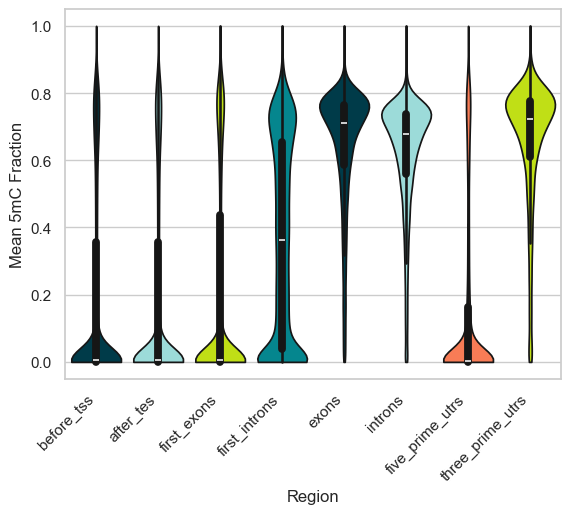

In [61]:
g = sns.violinplot(
    data=df,
    x="Region",
    y="mean_mc",
    hue="Region",
    order=column_order,
    cut=0,
    palette=biomodal_palette,
    saturation=1,
)
g.set_ylabel("Mean 5mC Fraction")
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right")
plt.show()

#### 5hmC levels in different regions

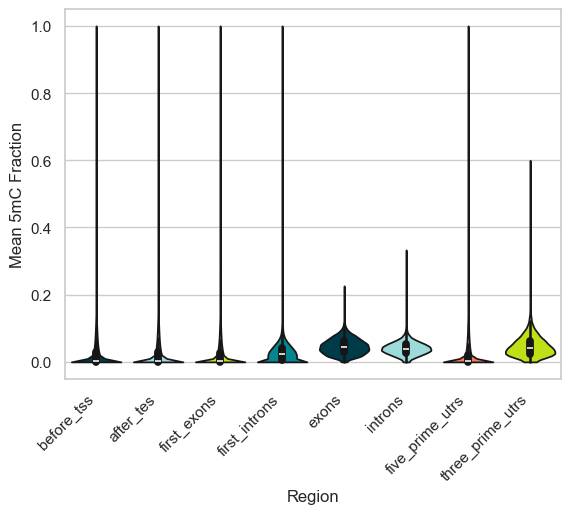

In [62]:
g = sns.violinplot(
    data=df,
    x="Region",
    y="mean_hmc",
    hue="Region",
    order=column_order,
    cut=0,
    palette=biomodal_palette,
    saturation=1,
)
# g.set_ylim(0,0.1)
g.set_ylabel("Mean 5mC Fraction")
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [68]:
df.columns

Index(['Gene_id', 'mean_mc', 'mean_hmc', 'mean_modc', 'cpg_count',
       'range_length', 'Gene_name', 'contig', 'Transcript_id', 'Region',
       'Sense'],
      dtype='object')

In [182]:
df['Sense'] = df['Sense'].replace(True, 'sense')
df['Sense'] = df['Sense'].replace(False, 'antisense')

In [192]:
df_pivot = df.pivot(
    index=["Gene_id", "Gene_name", "contig", "strand"],
    # index = ["Transcript_id", "contig", "strand"],
    columns=["Region", "Sense"],
    values=["mean_mc", "mean_hmc", "mean_modc", "cpg_count", "range_length"],
)

In [184]:
df_pivot

mean_mc                      \
Region                                         before_tss after_tes     genes   
Sense                                               Sense     Sense     Sense   
Gene_id               Gene_name  contig strand                                  
ENSMUSG00000000001.4  Gnai3      3      +             NaN       NaN  0.642745   
                                        -        0.000000  0.000000  0.643948   
ENSMUSG00000000003.15 Pbsn       X      +             NaN       NaN  0.739106   
                                        -             NaN       NaN  0.743048   
ENSMUSG00000000028.15 Cdc45      16     +             NaN       NaN  0.633455   
...                                                   ...       ...       ...   
ENSMUSG00000118640.1  AC167036.2 1      -        0.851459  0.851459  0.780381   
ENSMUSG00000118646.1  AC160405.1 10     +             NaN       NaN  0.765643   
                                        -        0.833333  0.833333  0.761150   
ENSMUSG00000118653.1  AC159819.1 9      +        0.278552  0.278552  0.280672   
                                        -             NaN       NaN  0.300631   

                                                                          \
Region                                         first_exons first_introns   
Sense                                                Sense         Sense   
Gene_id               Gene_name  contig strand                             
ENSMUSG00000000001.4  Gnai3      3      +              NaN           NaN   
                                        -         0.000455      0.585086   
ENSMUSG00000000003.15 Pbsn       X      +              NaN           NaN   
                                        -         0.719298      0.733333   
ENSMUSG00000000028.15 Cdc45      16     +              NaN           NaN   
...                                                    ...           ...   
ENSMUSG00000118640.1  AC167036.2 1      -         0.780381           NaN   
ENSMUSG00000118646.1  AC160405.1 10     +              NaN           NaN   
                                        -         0.777778      0.759917   
ENSMUSG00000118653.1  AC159819.1 9      +         0.280672           NaN   
                                        -              NaN           NaN   

                                                                               \
Region                                         before_tss after_tes     genes   
Sense                                           Antisense Antisense Antisense   
Gene_id               Gene_name  contig strand                                  
ENSMUSG00000000001.4  Gnai3      3      +        0.001415  0.001415  0.642745   
                                        -             NaN       NaN  0.643948   
ENSMUSG00000000003.15 Pbsn       X      +             NaN       NaN  0.739106   
                                        -             NaN       NaN  0.743048   
ENSMUSG00000000028.15 Cdc45      16     +        0.000000  0.000000  0.633455   
...                                                   ...       ...       ...   
ENSMUSG00000118640.1  AC167036.2 1      -             NaN       NaN  0.780381   
ENSMUSG00000118646.1  AC160405.1 10     +        0.860000  0.860000  0.765643   
                                        -             NaN       NaN  0.761150   
ENSMUSG00000118653.1  AC159819.1 9      +             NaN       NaN  0.280672   
                                        -        0.315934  0.315934  0.300631   

                                                                          ...  \
Region                                         first_exons first_introns  ...   
Sense                                            Antisense     Antisense  ...   
Gene_id               Gene_name  contig strand                            ...   
ENSMUSG00000000001.4  Gnai3      3      +         0.000000      0.577560  ...   
                                        -              NaN           NaN

In [185]:
df.Region.unique()

array(['before_tss', 'after_tes', 'genes', 'first_exons', 'first_introns',
       'exons', 'introns', 'five_prime_utrs', 'three_prime_utrs'],
      dtype=object)

In [186]:
##select contig==1 and Region == "before_tss" in df_replaced
df[(df["contig"] == "1") & (df["Region"] == "three_prime_utrs")][['Gene_id','Sense']].value_counts()

Gene_id                Sense    
ENSMUSG00000000544.14  Antisense    1
ENSMUSG00000040713.12  Sense        1
ENSMUSG00000040918.12  Sense        1
                       Antisense    1
ENSMUSG00000040848.11  Sense        1
                                   ..
ENSMUSG00000026327.8   Antisense    1
ENSMUSG00000026321.7   Sense        1
                       Antisense    1
ENSMUSG00000026319.13  Sense        1
ENSMUSG00000118219.1   Sense        1
Name: count, Length: 1868, dtype: int64

#### separate train and test dataset

In [ ]:
# extract 50% of each region from chromosome one for testing
# use remaining data for training

In [177]:
df_pivot.head(30)

mean_mc                      \
Region                                        before_tss after_tes     genes   
Sense                                              True      True      True    
Gene_id               Gene_name contig strand                                  
ENSMUSG00000000001.4  Gnai3     3      +             NaN       NaN  0.642745   
                                       -        0.000000  0.000000  0.643948   
ENSMUSG00000000003.15 Pbsn      X      +             NaN       NaN  0.739106   
                                       -             NaN       NaN  0.743048   
ENSMUSG00000000028.15 Cdc45     16     +             NaN       NaN  0.633455   
                                       -        0.000000  0.000000  0.646144   
ENSMUSG00000000037.17 Scml2     X      +        0.653846  0.653846  0.688475   
                                       -             NaN       NaN  0.692892   
ENSMUSG00000000049.11 Apoh      11     +        0.007270  0.007270  0.597976   
                                       -             NaN       NaN  0.613768   
ENSMUSG00000000056.7  Narf      11     +        0.000937  0.000937  0.574041   
                                       -             NaN       NaN  0.581271   
ENSMUSG00000000058.6  Cav2      6      +        0.028646  0.028646  0.541879   
                                       -             NaN       NaN  0.528901   
ENSMUSG00000000078.7  Klf6      13     +        0.000000  0.000000  0.266229   
                                       -             NaN       NaN  0.293563   
ENSMUSG00000000085.16 Scmh1     4      +        0.002132  0.002132  0.629530   
                                       -             NaN       NaN  0.626562   
ENSMUSG00000000088.7  Cox5a     9      +        0.001316  0.001316  0.207222   
                                       -             NaN       NaN  0.214271   
ENSMUSG00000000093.6  Tbx2      11     +        0.001105  0.001105  0.163753   
                                       -             NaN       NaN  0.168014   
ENSMUSG00000000094.12 Tbx4      11     +        0.074219  0.074219  0.475811   
                                       -             NaN       NaN  0.490660   
ENSMUSG00000000103.12 Zfy2      Y      +             NaN       NaN  0.773487   
                                       -        0.692308  0.692308  0.761722   
ENSMUSG00000000120.6  Ngfr      11     +             NaN       NaN  0.292079   
                                       -        0.003749  0.003749  0.289875   
ENSMUSG00000000125.5  Wnt3      11     +        0.001375  0.001375  0.539526   
                                       -             NaN       NaN  0.531585   

                                                                         \
Region                                        first_exons first_introns   
Sense                                               True          True    
Gene_id               Gene_name contig strand                             
ENSMUSG00000000001.4  Gnai3     3      +              NaN           NaN   
                                       -         0.000455      0.585086   
ENSMUSG00000000003.15 Pbsn      X      +              NaN           NaN   
                                       -         0.719298      0.733333   
ENSMUSG00000000028.15 Cdc45     16     +              NaN           NaN   
                                       -         0.000000           NaN   
ENSMUSG00000000037.17 Scml2     X      +         0.762557      0.730465   
                                       -              NaN           NaN   
ENSMUSG00000000049.11 Apoh      11     +         0.819620      0.540121   
                                       -              NaN           NaN   
ENSMUSG00000000056.7  Narf      11     +         0.001418      0.058977   
                                       -              NaN           NaN   
ENSMUSG00000000058.6  Cav2      6      +         0.041430      0.445946   
                                       -             

In [193]:
df_features = df_pivot.copy()

df_features.columns = [" ".join(col).strip() for col in df_features.columns.values]
features = df_features.columns
features

Index(['mean_mc before_tss sense', 'mean_mc after_tes sense',
       'mean_mc genes sense', 'mean_mc first_exons sense',
       'mean_mc first_introns sense', 'mean_mc before_tss antisense',
       'mean_mc after_tes antisense', 'mean_mc genes antisense',
       'mean_mc first_exons antisense', 'mean_mc first_introns antisense',
       'mean_mc exons sense', 'mean_mc introns sense',
       'mean_mc five_prime_utrs sense', 'mean_mc three_prime_utrs sense',
       'mean_mc exons antisense', 'mean_mc introns antisense',
       'mean_mc five_prime_utrs antisense',
       'mean_mc three_prime_utrs antisense', 'mean_hmc before_tss sense',
       'mean_hmc after_tes sense', 'mean_hmc genes sense',
       'mean_hmc first_exons sense', 'mean_hmc first_introns sense',
       'mean_hmc before_tss antisense', 'mean_hmc after_tes antisense',
       'mean_hmc genes antisense', 'mean_hmc first_exons antisense',
       'mean_hmc first_introns antisense', 'mean_hmc exons sense',
       'mean_hmc intron

In [194]:
# replace white spaces with underscores in features
# features = [f.replace("+", "plus") for f in features]
# features = [f.replace("-", "minus") for f in features]
features = [f.replace(" ", "_") for f in features]
df_features.columns = features
df_features

mean_mc_before_tss_sense  \
Gene_id               Gene_name  contig strand                             
ENSMUSG00000000001.4  Gnai3      3      +                            NaN   
                                        -                       0.000000   
ENSMUSG00000000003.15 Pbsn       X      +                            NaN   
                                        -                            NaN   
ENSMUSG00000000028.15 Cdc45      16     +                            NaN   
...                                                                  ...   
ENSMUSG00000118640.1  AC167036.2 1      -                       0.851459   
ENSMUSG00000118646.1  AC160405.1 10     +                            NaN   
                                        -                       0.833333   
ENSMUSG00000118653.1  AC159819.1 9      +                       0.278552   
                                        -                            NaN   

                                                mean_mc_after_tes_sense  \
Gene_id               Gene_name  contig strand                            
ENSMUSG00000000001.4  Gnai3      3      +                           NaN   
                                        -                      0.000000   
ENSMUSG00000000003.15 Pbsn       X      +                           NaN   
                                        -                           NaN   
ENSMUSG00000000028.15 Cdc45      16     +                           NaN   
...                                                                 ...   
ENSMUSG00000118640.1  AC167036.2 1      -                      0.851459   
ENSMUSG00000118646.1  AC160405.1 10     +                           NaN   
                                        -                      0.833333   
ENSMUSG00000118653.1  AC159819.1 9      +                      0.278552   
                                        -                           NaN   

                                                mean_mc_genes_sense  \
Gene_id               Gene_name  contig strand                        
ENSMUSG00000000001.4  Gnai3      3      +                  0.642745   
                                        -                  0.643948   
ENSMUSG00000000003.15 Pbsn       X      +                  0.739106   
                                        -                  0.743048   
ENSMUSG00000000028.15 Cdc45      16     +                  0.633455   
...                                                             ...   
ENSMUSG00000118640.1  AC167036.2 1      -                  0.780381   
ENSMUSG00000118646.1  AC160405.1 10     +                  0.765643   
                                        -                  0.761150   
ENSMUSG00000118653.1  AC159819.1 9      +                  0.280672   
                                        -                  0.300631   

                                                mean_mc_first_exons_sense  \
Gene_id               Gene_name  contig strand                              
ENSMUSG00000000001.4  Gnai3      3      +                             NaN   
                                        -                        0.000455   
ENSMUSG00000000003.15 Pbsn       X      +                             NaN   
                                        -                        0.719298   
ENSMUSG00000000028.15 Cdc45      16     +                             NaN   
...                                                                   ...   
ENSMUSG00000118640.1  AC167036.2 1      -                        0.780381   
ENSMUSG00000118646.1  AC160405.1 10     +                             NaN   
                                        -                        0.777778   
ENSMUSG00000118653.1  AC159819.1 9      +                        0.280672   
                                        -                             NaN   

                                                mean_mc_first_introns_sense  \
Gene_id               Gene_name  contig strand                                

## Extracting target

load truth set per transcript

In [342]:
ge_path = "../data/quant.sf"
df_expression = pd.read_csv(ge_path, sep="\t")
print(df_expression.shape)
df_expression.head()

(142699, 5)


,Name,Length,EffectiveLength,TPM,NumReads
0,ENSMUST00000193812.1,1070,884.760,0.000000,0.0
1,ENSMUST00000082908.1,110,10.723,0.000000,0.0
2,ENSMUST00000162897.1,4153,3967.760,0.000000,0.0
3,ENSMUST00000159265.1,2989,2803.760,0.088163,2.0
4,ENSMUST00000070533.4,3634,3448.760,0.000000,0.0


In [343]:
full_selected_transcript = pd.merge(selected_transcripts,transcripts, left_on='transcript_id', right_on='id', how='left')
full_selected_transcript

,gene_id_x,transcript_id_x,seq_id,source,type,start,end,score,strand,phase,...,transcript_name,level,transcript_support_level,mgi_id,tag,havana_gene,havana_transcript,protein_id,ccdsid,ont
0,ENSMUSG00000000001.4,ENSMUST00000000001.4,3,HAVANA,transcript,108107279,108146145,.,-,.,...,Gnai3-201,2,1,MGI:95773,"basic,appris_principal_1,CCDS",OTTMUSG00000007197.1,OTTMUST00000016610.1,ENSMUSP00000000001.4,CCDS17751.1,
1,ENSMUSG00000000003.15,ENSMUST00000000003.13,X,HAVANA,transcript,77837900,77853622,.,-,.,...,Pbsn-201,2,1,MGI:1860484,"basic,appris_principal_1,CCDS",OTTMUSG00000017891.1,OTTMUST00000043268.1,ENSMUSP00000000003.7,CCDS30249.1,
2,ENSMUSG00000000028.15,ENSMUST00000000028.13,16,HAVANA,transcript,18780446,18811971,.,-,.,...,Cdc45-201,2,1,MGI:1338073,"basic,appris_principal_1,CCDS",OTTMUSG00000026176.4,OTTMUST00000064673.1,ENSMUSP00000000028.7,CCDS28027.1,
3,ENSMUSG00000000037.17,ENSMUST00000101113.8,X,HAVANA,transcript,161117192,161256899,.,+,.,...,Scml2-205,2,5,MGI:1340042,"basic,appris_alternative_2",OTTMUSG00000019586.5,OTTMUST00000046920.2,ENSMUSP00000098672.2,,
4,ENSMUSG00000000049.11,ENSMUST00000000049.5,11,HAVANA,transcript,108395292,108414395,.,+,.,...,Apoh-201,2,1,MGI:88058,"basic,appris_principal_1,CCDS",OTTMUSG00000003129.2,OTTMUST00000006445.1,ENSMUSP00000000049.5,CCDS25574.1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,ENSMUSG00000118623.1,ENSMUST00000124129.7,2,HAVANA,transcript,120456018,120504772,.,+,.,...,AL935121.1-202,2,2,,"alternative_3_UTR,mRNA_start_NF,cds_start_NF,b...",OTTMUSG00000075009.2,OTTMUST00000036500.2,ENSMUSP00000159283.1,,
21537,ENSMUSG00000118638.1,ENSMUST00000239206.1,X,HAVANA,transcript,101818183,101821976,.,-,.,...,AL805980.1-201,2,,,"basic,appris_principal_1",OTTMUSG00000075023.1,OTTMUST00000182292.1,ENSMUSP00000159230.1,,
21538,ENSMUSG00000118640.1,ENSMUST00000239185.1,1,HAVANA,transcript,85027953,85028843,.,-,.,...,AC167036.2-201,2,,,"basic,appris_principal_1",OTTMUSG00000075005.1,OTTMUST00000182251.1,ENSMUSP00000159251.1,,
21539,ENSMUSG00000118646.1,ENSMUST00000239481.1,10,HAVANA,transcript,78288033,78307618,.,-,.,...,AC160405.1-201,2,,,"CAGE_supported_TSS,non_submitted_evidence,basi...",OTTMUSG00000075053.1,OTTMUST00000182412.1,ENSMUSP00000159333.1,,


In [344]:
# Merge df_expression with transcripts on the matching columns
merged_df = pd.merge(full_selected_transcript[['id', 'parent', 'strand']], df_expression, left_on='id', right_on='Name', how='left')


# Add the 'gene_id' column to df_expression
df_expression['Gene_id'] = merged_df['parent']
df_expression['strand'] = merged_df['strand']
df_expression_clean = df_expression[~df_expression.isna().any(axis=1)]
df_expression_clean

,Name,Length,EffectiveLength,TPM,NumReads,Gene_id,strand
0,ENSMUST00000193812.1,1070,884.760,0.000000,0.0,ENSMUSG00000000001.4,-
1,ENSMUST00000082908.1,110,10.723,0.000000,0.0,ENSMUSG00000000003.15,-
2,ENSMUST00000162897.1,4153,3967.760,0.000000,0.0,ENSMUSG00000000028.15,-
3,ENSMUST00000159265.1,2989,2803.760,0.088163,2.0,ENSMUSG00000000037.17,+
4,ENSMUST00000070533.4,3634,3448.760,0.000000,0.0,ENSMUSG00000000049.11,+
...,...,...,...,...,...,...,...
21536,ENSMUST00000192618.1,1109,923.760,0.000000,0.0,ENSMUSG00000118623.1,+
21537,ENSMUST00000082588.1,153,27.329,0.000000,0.0,ENSMUSG00000118638.1,-
21538,ENSMUST00000193942.1,259,97.280,0.000000,0.0,ENSMUSG00000118640.1,-
21539,ENSMUST00000182471.1,756,570.845,0.000000,0.0,ENSMUSG00000118646.1,-


In [345]:
# TODO: remove other columns from TPM df apart from TPM and Gene_id
df_expression_clean = df_expression_clean[["Gene_id", "TPM", "strand"]]

df_features_expression = pd.merge(
    df_features,
    df_expression_clean,
    on=["Gene_id","strand"],
    how="inner",
)
df_features_expression

,Gene_id,strand,mean_mc_before_tss_sense,mean_mc_after_tes_sense,mean_mc_genes_sense,mean_mc_first_exons_sense,mean_mc_first_introns_sense,mean_mc_before_tss_antisense,mean_mc_after_tes_antisense,mean_mc_genes_antisense,...,range_length_first_introns_antisense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,range_length_exons_antisense,range_length_introns_antisense,range_length_five_prime_utrs_antisense,range_length_three_prime_utrs_antisense,TPM
0,ENSMUSG00000000001.4,-,0.000000,0.000000,0.643948,0.000455,0.585086,NaN,NaN,0.643948,...,NaN,2995.0,13562.0,140.0,2054.0,2995.0,13562.0,140.0,2054.0,0.000000
1,ENSMUSG00000000003.15,-,NaN,NaN,0.743048,0.719298,0.733333,NaN,NaN,0.743048,...,NaN,681.0,9532.0,139.0,235.0,681.0,9532.0,139.0,235.0,0.000000
2,ENSMUSG00000000028.15,-,0.000000,0.000000,0.646144,0.000000,NaN,NaN,NaN,0.646144,...,NaN,1955.0,29402.0,311.0,127.0,1955.0,29402.0,311.0,127.0,0.000000
3,ENSMUSG00000000037.17,+,0.653846,0.653846,0.688475,0.762557,0.730465,NaN,NaN,0.688475,...,NaN,2777.0,138112.0,NaN,NaN,2777.0,138112.0,NaN,NaN,0.088163
4,ENSMUSG00000000049.11,+,0.007270,0.007270,0.597976,0.819620,0.540121,NaN,NaN,0.597976,...,NaN,1068.0,17921.0,50.0,100.0,1068.0,17921.0,50.0,100.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,ENSMUSG00000118623.1,+,0.512397,0.512397,0.595370,0.764444,0.607668,NaN,NaN,0.595370,...,NaN,2782.0,44783.0,NaN,NaN,2782.0,44783.0,NaN,NaN,0.000000
21537,ENSMUSG00000118638.1,-,0.870370,0.870370,0.712744,0.793194,NaN,NaN,NaN,0.712744,...,NaN,580.0,1162.0,NaN,NaN,580.0,1162.0,NaN,NaN,0.000000
21538,ENSMUSG00000118640.1,-,0.851459,0.851459,0.780381,0.780381,NaN,NaN,NaN,0.780381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
21539,ENSMUSG00000118646.1,-,0.833333,0.833333,0.761150,0.777778,0.759917,NaN,NaN,0.761150,...,NaN,39.0,NaN,NaN,NaN,39.0,NaN,NaN,NaN,0.000000


In [346]:
df_features_expression["Gene_id"].value_counts()

Gene_id
ENSMUSG00000000001.4     1
ENSMUSG00000050266.6     1
ENSMUSG00000050296.14    1
ENSMUSG00000050295.4     1
ENSMUSG00000050288.6     1
                        ..
ENSMUSG00000029381.16    1
ENSMUSG00000029380.11    1
ENSMUSG00000029379.10    1
ENSMUSG00000029378.5     1
ENSMUSG00000118653.1     1
Name: count, Length: 21541, dtype: int64

## Feature Importance

In [348]:
features = df_features_expression.drop(["Gene_id"], axis=1)

In [349]:
features["strand"] = features["strand"].replace('+', 1)
features["strand"] = features["strand"].replace('-', 0)
features

,strand,mean_mc_before_tss_sense,mean_mc_after_tes_sense,mean_mc_genes_sense,mean_mc_first_exons_sense,mean_mc_first_introns_sense,mean_mc_before_tss_antisense,mean_mc_after_tes_antisense,mean_mc_genes_antisense,mean_mc_first_exons_antisense,...,range_length_first_introns_antisense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,range_length_exons_antisense,range_length_introns_antisense,range_length_five_prime_utrs_antisense,range_length_three_prime_utrs_antisense,TPM
0,0,0.000000,0.000000,0.643948,0.000455,0.585086,NaN,NaN,0.643948,NaN,...,NaN,2995.0,13562.0,140.0,2054.0,2995.0,13562.0,140.0,2054.0,0.000000
1,0,NaN,NaN,0.743048,0.719298,0.733333,NaN,NaN,0.743048,NaN,...,NaN,681.0,9532.0,139.0,235.0,681.0,9532.0,139.0,235.0,0.000000
2,0,0.000000,0.000000,0.646144,0.000000,NaN,NaN,NaN,0.646144,NaN,...,NaN,1955.0,29402.0,311.0,127.0,1955.0,29402.0,311.0,127.0,0.000000
3,1,0.653846,0.653846,0.688475,0.762557,0.730465,NaN,NaN,0.688475,NaN,...,NaN,2777.0,138112.0,NaN,NaN,2777.0,138112.0,NaN,NaN,0.088163
4,1,0.007270,0.007270,0.597976,0.819620,0.540121,NaN,NaN,0.597976,NaN,...,NaN,1068.0,17921.0,50.0,100.0,1068.0,17921.0,50.0,100.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,1,0.512397,0.512397,0.595370,0.764444,0.607668,NaN,NaN,0.595370,NaN,...,NaN,2782.0,44783.0,NaN,NaN,2782.0,44783.0,NaN,NaN,0.000000
21537,0,0.870370,0.870370,0.712744,0.793194,NaN,NaN,NaN,0.712744,NaN,...,NaN,580.0,1162.0,NaN,NaN,580.0,1162.0,NaN,NaN,0.000000
21538,0,0.851459,0.851459,0.780381,0.780381,NaN,NaN,NaN,0.780381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
21539,0,0.833333,0.833333,0.761150,0.777778,0.759917,NaN,NaN,0.761150,NaN,...,NaN,39.0,NaN,NaN,NaN,39.0,NaN,NaN,NaN,0.000000


In [350]:
# Step 2: Calculate null values per column
null_counts = features.isnull().sum()

# Step 3: Calculate percentages
total_rows = len(features)
null_percentages = (null_counts / total_rows) * 100
print(null_percentages.sort_values(ascending=False))

mean_modc_first_introns_antisense       100.0
mean_hmc_before_tss_antisense           100.0
range_length_before_tss_antisense       100.0
range_length_first_introns_antisense    100.0
cpg_count_first_introns_antisense       100.0
                                        ...  
cpg_count_first_exons_sense               0.0
cpg_count_genes_sense                     0.0
cpg_count_after_tes_sense                 0.0
cpg_count_before_tss_sense                0.0
TPM                                       0.0
Length: 92, dtype: float64


In [351]:
null_columns = list(null_percentages[null_percentages>=30].index)
print( f"{len(null_columns) } columns with 100% missing values")

32 columns with 100% missing values


In [352]:
clean_features = features.drop(null_columns, axis=1)
len(clean_features.columns)

60

In [353]:
null_columns

['mean_mc_before_tss_antisense',
 'mean_mc_after_tes_antisense',
 'mean_mc_first_exons_antisense',
 'mean_mc_first_introns_antisense',
 'mean_mc_five_prime_utrs_sense',
 'mean_mc_three_prime_utrs_sense',
 'mean_mc_five_prime_utrs_antisense',
 'mean_mc_three_prime_utrs_antisense',
 'mean_hmc_before_tss_antisense',
 'mean_hmc_after_tes_antisense',
 'mean_hmc_first_exons_antisense',
 'mean_hmc_first_introns_antisense',
 'mean_hmc_five_prime_utrs_sense',
 'mean_hmc_three_prime_utrs_sense',
 'mean_hmc_five_prime_utrs_antisense',
 'mean_hmc_three_prime_utrs_antisense',
 'mean_modc_before_tss_antisense',
 'mean_modc_after_tes_antisense',
 'mean_modc_first_exons_antisense',
 'mean_modc_first_introns_antisense',
 'mean_modc_five_prime_utrs_sense',
 'mean_modc_three_prime_utrs_sense',
 'mean_modc_five_prime_utrs_antisense',
 'mean_modc_three_prime_utrs_antisense',
 'cpg_count_before_tss_antisense',
 'cpg_count_after_tes_antisense',
 'cpg_count_first_exons_antisense',
 'cpg_count_first_introns_an

In [354]:
clean_features

,strand,mean_mc_before_tss_sense,mean_mc_after_tes_sense,mean_mc_genes_sense,mean_mc_first_exons_sense,mean_mc_first_introns_sense,mean_mc_genes_antisense,mean_mc_exons_sense,mean_mc_introns_sense,mean_mc_exons_antisense,...,range_length_genes_antisense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,range_length_exons_antisense,range_length_introns_antisense,range_length_five_prime_utrs_antisense,range_length_three_prime_utrs_antisense,TPM
0,0,0.000000,0.000000,0.643948,0.000455,0.585086,0.643948,0.807449,0.780230,0.810206,...,38866.0,2995.0,13562.0,140.0,2054.0,2995.0,13562.0,140.0,2054.0,0.000000
1,0,NaN,NaN,0.743048,0.719298,0.733333,0.743048,0.775309,0.736125,0.746445,...,15722.0,681.0,9532.0,139.0,235.0,681.0,9532.0,139.0,235.0,0.000000
2,0,0.000000,0.000000,0.646144,0.000000,NaN,0.646144,0.581154,0.690302,0.557178,...,31540.0,1955.0,29402.0,311.0,127.0,1955.0,29402.0,311.0,127.0,0.000000
3,1,0.653846,0.653846,0.688475,0.762557,0.730465,0.688475,0.758958,0.671574,0.765890,...,175688.0,2777.0,138112.0,NaN,NaN,2777.0,138112.0,NaN,NaN,0.088163
4,1,0.007270,0.007270,0.597976,0.819620,0.540121,0.597976,0.783202,0.770473,0.794449,...,71042.0,1068.0,17921.0,50.0,100.0,1068.0,17921.0,50.0,100.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,1,0.512397,0.512397,0.595370,0.764444,0.607668,0.595370,0.660543,0.578073,0.659332,...,48754.0,2782.0,44783.0,NaN,NaN,2782.0,44783.0,NaN,NaN,0.000000
21537,0,0.870370,0.870370,0.712744,0.793194,NaN,0.712744,0.702595,0.454128,0.688699,...,3793.0,580.0,1162.0,NaN,NaN,580.0,1162.0,NaN,NaN,0.000000
21538,0,0.851459,0.851459,0.780381,0.780381,NaN,0.780381,NaN,NaN,NaN,...,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
21539,0,0.833333,0.833333,0.761150,0.777778,0.759917,0.761150,0.778325,NaN,0.808824,...,19585.0,39.0,NaN,NaN,NaN,39.0,NaN,NaN,NaN,0.000000


In [365]:
# fill na values with 0 in all columns
clean_features = clean_features.fillna(0)

# fill na values with 0 in range_length columns
range_length_columns = [col for col in clean_features.columns if "range_length" in col]
clean_features[range_length_columns] = clean_features[range_length_columns].fillna(0)

# standardize the data in range_length columns
from sklearn.preprocessing import MinMaxScaler
clean_features[range_length_columns] = MinMaxScaler().fit_transform(clean_features[range_length_columns])
clean_features

,strand,mean_mc_before_tss_sense,mean_mc_after_tes_sense,mean_mc_genes_sense,mean_mc_first_exons_sense,mean_mc_first_introns_sense,mean_mc_genes_antisense,mean_mc_exons_sense,mean_mc_introns_sense,mean_mc_exons_antisense,...,range_length_genes_antisense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,range_length_exons_antisense,range_length_introns_antisense,range_length_five_prime_utrs_antisense,range_length_three_prime_utrs_antisense,TPM
0,0,0.000000,0.000000,0.643948,0.000455,0.585086,0.643948,0.807449,0.780230,0.810206,...,0.008746,0.024345,0.004649,0.030356,0.016756,0.024345,0.004649,0.030356,0.016756,0.000000
1,0,0.000000,0.000000,0.743048,0.719298,0.733333,0.743048,0.775309,0.736125,0.746445,...,0.003528,0.005536,0.003268,0.030139,0.001917,0.005536,0.003268,0.030139,0.001917,0.000000
2,0,0.000000,0.000000,0.646144,0.000000,0.000000,0.646144,0.581154,0.690302,0.557178,...,0.007095,0.015891,0.010079,0.067433,0.001036,0.015891,0.010079,0.067433,0.001036,0.000000
3,1,0.653846,0.653846,0.688475,0.762557,0.730465,0.688475,0.758958,0.671574,0.765890,...,0.039598,0.022573,0.047344,0.000000,0.000000,0.022573,0.047344,0.000000,0.000000,0.088163
4,1,0.007270,0.007270,0.597976,0.819620,0.540121,0.597976,0.783202,0.770473,0.794449,...,0.016002,0.008681,0.006143,0.010841,0.000816,0.008681,0.006143,0.010841,0.000816,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,1,0.512397,0.512397,0.595370,0.764444,0.607668,0.595370,0.660543,0.578073,0.659332,...,0.010976,0.022614,0.015351,0.000000,0.000000,0.022614,0.015351,0.000000,0.000000,0.000000
21537,0,0.870370,0.870370,0.712744,0.793194,0.000000,0.712744,0.702595,0.454128,0.688699,...,0.000838,0.004715,0.000398,0.000000,0.000000,0.004715,0.000398,0.000000,0.000000,0.000000
21538,0,0.851459,0.851459,0.780381,0.780381,0.000000,0.780381,0.000000,0.000000,0.000000,...,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21539,0,0.833333,0.833333,0.761150,0.777778,0.759917,0.761150,0.778325,0.000000,0.808824,...,0.004399,0.000317,0.000000,0.000000,0.000000,0.000317,0.000000,0.000000,0.000000,0.000000


In [366]:
# split the data into features and target
y = clean_features['TPM']
X = clean_features.drop(["TPM"], axis=1)

# bin the TPM values into binary classes, of value above 0 or 0
y = y > 0

In [367]:
X

,strand,mean_mc_before_tss_sense,mean_mc_after_tes_sense,mean_mc_genes_sense,mean_mc_first_exons_sense,mean_mc_first_introns_sense,mean_mc_genes_antisense,mean_mc_exons_sense,mean_mc_introns_sense,mean_mc_exons_antisense,...,range_length_first_introns_sense,range_length_genes_antisense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,range_length_exons_antisense,range_length_introns_antisense,range_length_five_prime_utrs_antisense,range_length_three_prime_utrs_antisense
0,0,0.000000,0.000000,0.643948,0.000455,0.585086,0.643948,0.807449,0.780230,0.810206,...,0.005029,0.008746,0.024345,0.004649,0.030356,0.016756,0.024345,0.004649,0.030356,0.016756
1,0,0.000000,0.000000,0.743048,0.719298,0.733333,0.743048,0.775309,0.736125,0.746445,...,0.001208,0.003528,0.005536,0.003268,0.030139,0.001917,0.005536,0.003268,0.030139,0.001917
2,0,0.000000,0.000000,0.646144,0.000000,0.000000,0.646144,0.581154,0.690302,0.557178,...,0.000003,0.007095,0.015891,0.010079,0.067433,0.001036,0.015891,0.010079,0.067433,0.001036
3,1,0.653846,0.653846,0.688475,0.762557,0.730465,0.688475,0.758958,0.671574,0.765890,...,0.007907,0.039598,0.022573,0.047344,0.000000,0.000000,0.022573,0.047344,0.000000,0.000000
4,1,0.007270,0.007270,0.597976,0.819620,0.540121,0.597976,0.783202,0.770473,0.794449,...,0.011846,0.016002,0.008681,0.006143,0.010841,0.000816,0.008681,0.006143,0.010841,0.000816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,1,0.512397,0.512397,0.595370,0.764444,0.607668,0.595370,0.660543,0.578073,0.659332,...,0.000251,0.010976,0.022614,0.015351,0.000000,0.000000,0.022614,0.015351,0.000000,0.000000
21537,0,0.870370,0.870370,0.712744,0.793194,0.000000,0.712744,0.702595,0.454128,0.688699,...,0.000141,0.000838,0.004715,0.000398,0.000000,0.000000,0.004715,0.000398,0.000000,0.000000
21538,0,0.851459,0.851459,0.780381,0.780381,0.000000,0.780381,0.000000,0.000000,0.000000,...,0.000000,0.000183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21539,0,0.833333,0.833333,0.761150,0.777778,0.759917,0.761150,0.778325,0.000000,0.808824,...,0.004380,0.004399,0.000317,0.000000,0.000000,0.000000,0.000317,0.000000,0.000000,0.000000


In [368]:
y

0        False
1        False
2        False
3         True
4        False
         ...  
21536    False
21537    False
21538    False
21539    False
21540    False
Name: TPM, Length: 21541, dtype: bool

In [373]:
# train XGBoost model
import xgboost
import shap


X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution



model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

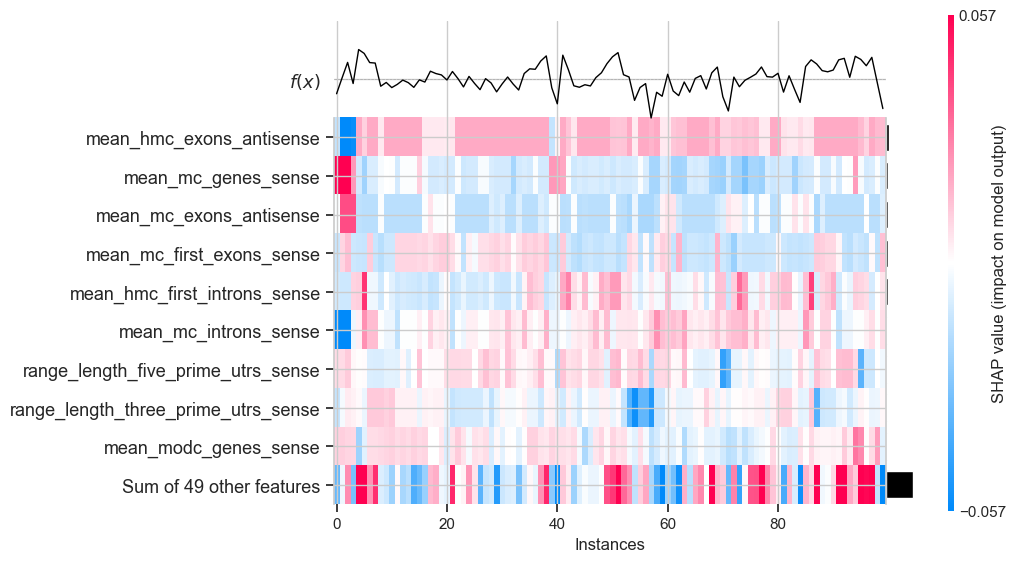

<Axes: xlabel='Instances'>

In [374]:
sense_columns = [col for col in clean_features.columns if "sense" in col]
antisense_columns = [col for col in clean_features.columns if "antisense" in col]

shap.plots.heatmap(shap_values_xgb[:100, sense_columns])

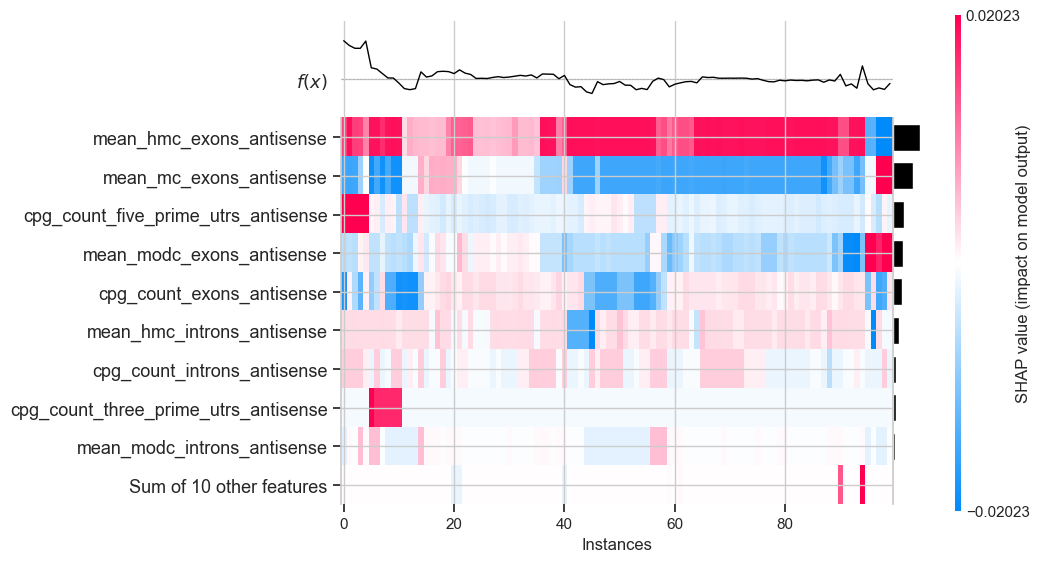

<Axes: xlabel='Instances'>

In [375]:
shap.plots.heatmap(shap_values_xgb[:100, antisense_columns])

In [380]:
clustering = shap.utils.hclust(X, y)

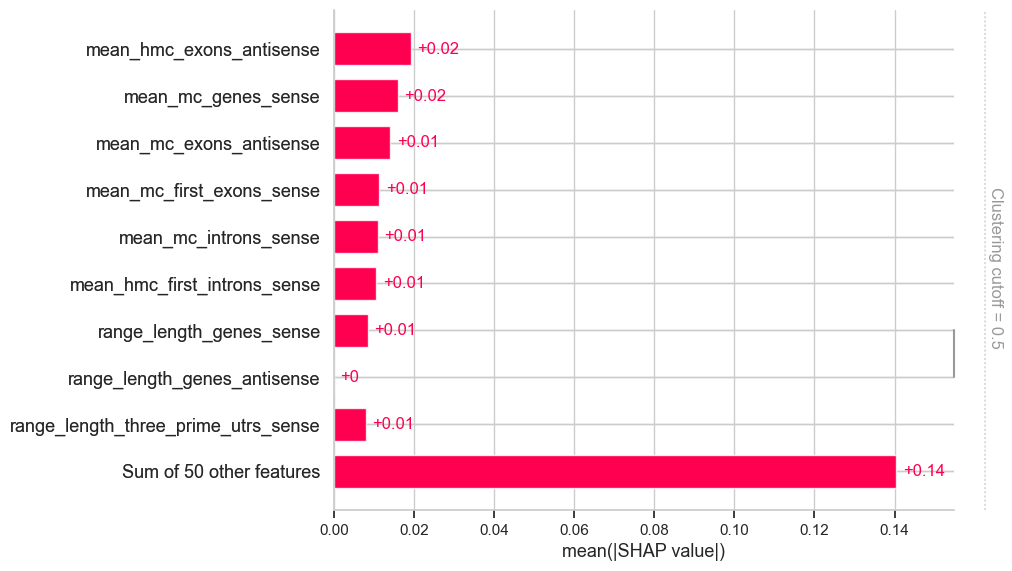

In [381]:
shap.plots.bar(shap_values_xgb, clustering=clustering)

In [372]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Evaluate feature importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the feature importances
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the results
print("Feature Importances:")
print(feature_importances)

Feature Importances:
                                    Feature  Importance
48           range_length_first_exons_sense    0.026270
49         range_length_first_introns_sense    0.022984
50             range_length_genes_antisense    0.022163
47                 range_length_genes_sense    0.022061
16                 mean_hmc_genes_antisense    0.021648
51                 range_length_exons_sense    0.021585
13                     mean_hmc_genes_sense    0.021546
19                 mean_hmc_exons_antisense    0.021489
36                cpg_count_genes_antisense    0.020955
33                    cpg_count_genes_sense    0.020887
17                     mean_hmc_exons_sense    0.020485
55             range_length_exons_antisense    0.020484
6                   mean_mc_genes_antisense    0.020077
3                       mean_mc_genes_sense    0.020020
26                mean_modc_genes_antisense    0.019509
9                   mean_mc_exons_antisense    0.019496
23                    mean_

## Data Partitioning

In [ ]:
# from scipy.stats import spearmanr
# from sklearn.metrics import (
#     accuracy_score,
#     mean_absolute_error,
#     mean_squared_error,
#     root_mean_squared_error,
#     r2_score,
#     roc_auc_score,
#     f1_score,
# )
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import GridSearchCV
# import xgboost as xgb